In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

# <h60><center> Massive Data Storage, Retrieval, and Deep Learning 198:543<br> Project Final Report 
### <center> Professor Gerard de Melo
## <center> Technology Stock Prediction Using Website Traffic and Sentiment of News Articles.<br>Is there a Correlation between, Online Web Traffic, Sentiment of News and Financial Markets?
### <center> By (Group 99) Akash Desai and William Cheng

***

<a id="toc"></a>
# Table of Contents
> ### 1. [Introduction to Problem and Methods](#toc1)
>> #### a. [Related Work](#toc1)
> ### 2. [Data Preprocessing and Exploration](#toc2)
>> #### a. [News Articles](#toc2a)
>> #### b. [Wikipedia Site Visits](#toc2b)
> ###  3. [Training Models](#toc3)
>> #### a. [Machine Learning](#toc3a)
>> #### b. [Deep Learning](#toc3b)
> ###  4. [Results](#toc4)
> ###  5. [Future Outlook](#toc5)
> ###  5. [References](#toc6)

***

<a id="toc1"></a>
# 1. Introduction to Problem and Methods

<font size=4>
  The goal behind this project is to access the approaches available for time series datasets. While doing that we are trying to understand the tools available to really understand the potential to unlock the vast amount of time series available through a recent proliferation in sensor data, and readily available datasets through websites like Kaggle. 

  Time series data set we use are Wikipedia dataset on the number of visits for an article, Stock price of a company (Amazon) and news articles for sentiment analysis.

  Along this project we ended up finding few interesting things within our dataset while we were exploring it and we included that in project to gain insight regarding the topic. 

  We are also focusing on whether we can predict the number of the visits for an article, and lastly, we were fascinated with financial markets and wanted to see if we could combine this knowledge gathered from Wikipedia and sentiment analysis to get a more accurate stock prediction model. 

  As financial market is one of most sought after fields and with its readily available time series data, it made us dive deeper and see if the number of visits for a company page on Wikipedia which meant there was some ongoing "buzz" about the company, affected the price of its stock, this idea was further reinforced by whether there was good sentiment towards the company in news articles published during that time.

  We choose this project, because we saw the simplicity that existed within time series datasets. As there are so many different applications where this can be applied, exploring this field seemed really fascinating. Finding patterns in available dataset and seeing if we can better predict with conjunction another dataset is quite interesting.  Below we can see the immense growth of the time series data set.
</font>

<img src="https://www.captechconsulting.com/blogs/library/6261d022e25647f58a16feefcdc4ec7c.ashx?la=en" alt="Drawing" style="width: 800px;"/>

<a id="toc1a"></a>
# Related Work

#### The Wikipedia Visits Features

Our motivation for using Wikipedia Visits comes here this paper:
<br>
<br>
`Dondio, P. (2013, January 7). Stock Market Prediction without Sentiment Analysis: Using a Web-Traffic Based Classifier and User-Level Analysis. Retrieved from https://ieeexplore.ieee.org/document/6480222.`

#### The News Article Sentiment Features

Our motivation for using News Article Sentiments come from this paper:
<br>
<br>
`Kaya, Y. (n.d.). Stock Price Prediction Using Financial News Articles. Retrieved from https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5609404&tag=1`

#### Improvements on Designs
In the aforementioned papers where we got our motivation to do this project, the responses that their models output are binary, meaning that they only predict whether a certain stock price goes up or down. They were able to get results better than that of random choice with a binary approach. However, we would like to expand on this by using regression to predict a more precise stock price or change in stock price. Also, we want to improve on those designs by introducing not only relevant words from the news articles, but their sentiment as well.


In [2]:
import os
import json
import csv
import re
from glob import glob

# arithmatic libraries
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# data preprocessing libraries
import pyspark
from pyspark import SparkContext

# sentiment analysis
from textblob import TextBlob as tb
import nltk
nltk.download('punkt')

# statistics libraries
import re
from collections import Counter
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# ML libraries
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from datetime import datetime, timedelta

#Deep learning 
import tensorflow as tf
from tensorflow.contrib import rnn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
#visualization
# plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

[nltk_data] Downloading package punkt to /home/willc97/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using TensorFlow backend.


<a id="toc2"></a>
# 2. Data Preprocessing

<div class="alert alert-block alert-info">
<b>Note on Spark Framework:</b> We use the Spark Framework to process a lot of our data. Much of our preprocessing can take lots of time, so having the ability to run our jobs in parallel is very advantageous for our computations!
</div>

<a id="toc2a"></a>
# 2a. Data Exploration: News Articles

### Why we want to use News Articles in Prediction:
<br>
We want to look at how influential news articles are to the movement of stocks of technology companies. News articles are read by many people and may influence the thoughts and actions of others, especially stock traders. This is due to the fact that news articles are one of the main sources that people receive information.
<br>
<br>
We want to look at the sentiment of news articles, meaning the polarity and subjectivity of the news articles, so we run sentiment analysis on the content within news articles. 
<br>
<br>We also want to make sure that the news articles that we have in our dataset are related to technology companies, so we use cosine similarity analysis to look at how related a news article is to keywords that relate to technology companies. We reduce the runtime cost of running cosine similarity analysis on all the text of news articles by finding at most 30 words with the highest TFIDF scores.
<br>
<br>
In the end, the dates, polarity scores, subjectivity scores, and cosine similarity scores are all processed to be used as part of the dataset to trian our Technology Stock Prediction Model.

#### Filter out articles that are not within or around our dates of interest. <br><br> We start off by looking at the most recent years of the dataset: 2015, 2016, and 2017

In [3]:
articles_df = pd.DataFrame(columns=['title', 'publication', 'date', 'year', 'month', 'content'])
for name in  ['articles1.csv', 'articles1.csv', 'articles1.csv']:
    temp_df = pd.read_csv('data/raw/all-the-news/{article_name}'.format(article_name=name))
    temp_df = temp_df[['title', 'publication', 'date', 'year', 'month', 'content']]
    temp_df = temp_df.where((temp_df.year == 2015.0) | (temp_df.year == 2016.0) | (temp_df.year == 2017.0)).dropna()
    articles_df = pd.concat([articles_df, temp_df])

##### Add a day field because we will be needing this information late in the preprocessing steps

In [4]:
articles_df = articles_df[['title', 'publication', 'date', 'year', 'month', 'content']]
articles_df['day'] = articles_df.apply(lambda row: float(row.date[-2:]), axis=1)

In [5]:
for year in range(2015, 2017+1):
    for month in range(1, 12+1):
        file_name = 'data/filtered/all-the-news/articles_{year}_{month:02}.csv'.format(year=year, month=month)
        temp_df = articles_df.where((articles_df.year == year) & (articles_df.month == month)).dropna().drop_duplicates(subset=['title'])
        if len(temp_df) != 0:
            temp_df.to_csv(file_name, index=False)

##### Plot of numbers of articles for every month from 2015 to 2017

Our results show that there is a significant number of articles for each month of 2016. There is at least 1500 articles from January to Decemeber in 2016.
<br>
We choose to use our dataset within 2016 to build our model because it has data for the entire year of 2016.

<div class="alert alert-block alert-danger">
<b>Notice:</b> The cell below will take very long to run.
</div>

In [6]:
filtered_df = pd.DataFrame(columns=['title', 'publication', 'date', 'year', 'month', 'content'])
for year in range(2015, 2017+1):
    for month in range(1, 12+1):
        file_name = 'data/filtered/all-the-news/articles_{year}_{month:02}.csv'.format(year=year, month=month)
        temp_df = pd.read_csv(file_name)
        filtered_df = pd.concat([filtered_df, temp_df])
filtered_df['YYYY_MM'] = filtered_df.apply(lambda row: row.date[:7], axis=1)

In [7]:
count_articles_df = filtered_df.YYYY_MM.value_counts().to_frame().sort_index()

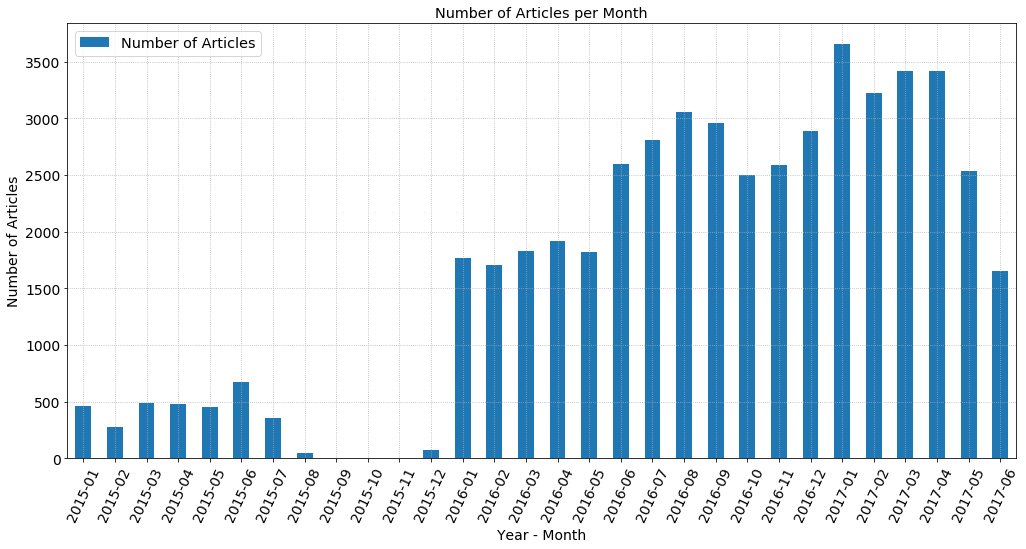

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False)
fig.set_size_inches(17, 8)
fig.subplots_adjust(hspace=.5)

count_articles_plot_args = {
    'kind' : 'bar',
    'fontsize' : 14,
    'title' : 'Number of Articles per Month',
    'ax' : axes,
    'rot' : 65
}

count_articles_plot = count_articles_df.plot(**count_articles_plot_args)
count_articles_plot.set_ylabel('Number of Articles', fontsize=14)
count_articles_plot.set_xlabel('Year - Month', fontsize=14)
count_articles_plot.grid('on', which='both', linestyle=':')

axes.legend(['Number of Articles'], loc='best')

[Back to Table of Contents](#toc)

## Sentiment (Subjectivity, Polarity) and<br>TFIDF (Term Frequency-Inverse Document Frequency)<br>of News Articles

### Details of TFIDF and Sentiment Analysis Step

### Sentiment:
We analyze the sentiment of the content of each article. We want to do this because we want to use the sentiment in our stock prediction machine learning or deep learning model and see if the sentiment of popular news articles affect stock prices. The sentiment that we analyze from each article involves two parts. 
<br>
<br>
Part one of the sentiment is the subjectivity, and part two is the polarity.
<br>
Polarity scores range from -1.0 to 1.0
Sentiment scores from range 0.0 to 1.0
<br>
<br>
##### Subjectivity:
The subjectivity is the expression of personal views or beliefs, and it indicates whether a text has sentiment or not. A higher subjectivity score indicates a more subjective text, and a lower subjectivity score indicates a more objective text.
<br>
<br>
##### Polarity:
The polarity score indicates the emotions expressed, and is closely related to the type of sentiment. A higher polarity score indicates a more positive text, and a lower polarity score indicates a more negative text. Also, a polarity score of 0 indicates neutrality.

### TFIDF:
We analyze the TFIDF of each article and take a maximum of 30 words from each article with the largest TFIDF score. We use the words with the top TFIDF score in each article to find the cosine similarity to a given set of keywords. Analyzing the TFIDF of the articles will give us a more accurate indication of how related an article is to the a set of key words to that give, i.e. key words could be ('technology', 'phone', 'internet', 'security'). The example set ofkeywords will allow us to find articles that relate to technology companies and find the accurate sentiment from news articles about these companies.

In [19]:
def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)
    
def strtolower(s):
    return s.lower()

def analyze_news_articles(args):
    input_folder, output_folder, articles_name = args
    articles = os.path.join(input_folder, articles_name)
    
    month_df = pd.read_csv(articles)
    
    results = dict()
    results['data'] = list()
    
    for day in range(1, 31+1):
        day_df = month_df.where(month_df.day == day).dropna()
        if len(day_df) == 0:
            continue 
            
        titles = list(day_df.title)
        years = list(day_df.year)
        months = list(day_df.month)
        contents = list(day_df.content)
        bloblist = list(map(tb, list(map(strtolower, contents))))
        
        results['year'] = years[0]
        results['month'] = months[0]
        
        for i, blob in enumerate(bloblist):
            scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
            sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)

            result = dict()
            result['title'] = titles[i]
            result['year'] = years[i]
            result['month'] = months[i]
            result['day'] = day

            sentiment = tb(contents[i]).sentiment
            result['polarity'] = sentiment.polarity
            result['subjectivity'] = sentiment.subjectivity
            
            num_dist_words = len(sorted_words)
            result['tdidf'] = sorted_words[:min(30, num_dist_words)]

            results['data'].append(result)
    
    output_name = os.path.join(output_folder, articles_name.replace('.csv', '.json'))
        
    with open(output_name, 'w') as outfile:
        json.dump(results, outfile)
        
    return (output_name, len(results['data']))

In [20]:
input_folder = 'data/filtered/all-the-news/'
output_folder = 'data/tfidf/all-the-news/'
articles_names = os.listdir(input_folder)
arguments = [(input_folder, output_folder, articles_name) for articles_name in articles_names]

<div class="alert alert-block alert-danger">
<b>Notice:</b> We turned the cell below to markdown so we do not accidentally run it again, as it takes a very long time to run.
</div>

```python
print('Starting analysis')
sc = pyspark.SparkContext(appName='News Articles')
process_tdidf_by_month = sc.parallelize(arguments, len(arguments)).map(analyze_news_articles)
collect_tdidf_by_month = process_tdidf_by_month.collect()
sc.stop()
print('Finished analysis')
```

[Back to Table of Contents](#toc)

### Analysis of Sentiments
<br>
We look at the analyze the polarity and sentiment scores for each given month from 2015 to 2017. In the boxplots below, we see that the mean subjectivity and polarity scores stay nearly the same across all the months, apart from the couple months in 2015 where we do not have enough data.

In [21]:
def retrieve_tfidf_sentiment(args):
    input_folder, output_folder, articles_name = args
    articles_path = os.path.join(output_folder, articles_name.replace('.csv', '.json'))
    
    with open(articles_path) as f:
        month = json.load(f)
    
    month_df = pd.DataFrame()
    
    for day in month['data']:
        day['tdidf'] = len(day['tdidf'])

        for key, value in day.items():
            day[key] = [value]
            
        day['YYYY_MM'] = '{YYYY:04}-{MM:02}'.format(YYYY=int(month['year']), MM=int(month['month']))
        
        day_df = pd.DataFrame.from_dict(day)
        month_df = month_df.append(day_df)
        
    return month_df

<div class="alert alert-block alert-danger">
<b>Notice:</b> The cell below will take very long to run.
</div>

In [22]:
tfidf_sentiment_df = pd.DataFrame()
temp_dfs = list()

for argument in arguments:
    temp_dfs.append(retrieve_tfidf_sentiment(argument))

In [23]:
tfidf_sentiment_df = pd.concat(temp_dfs).reset_index(drop=True)

sentiment_polarity = tfidf_sentiment_df.drop(columns=['title', 'year', 'month', 
                                                      'day', 'tdidf', 'subjectivity'])
sentiment_subjectivity = tfidf_sentiment_df.drop(columns=['title', 'year', 'month', 
                                                      'day', 'tdidf', 'polarity'])

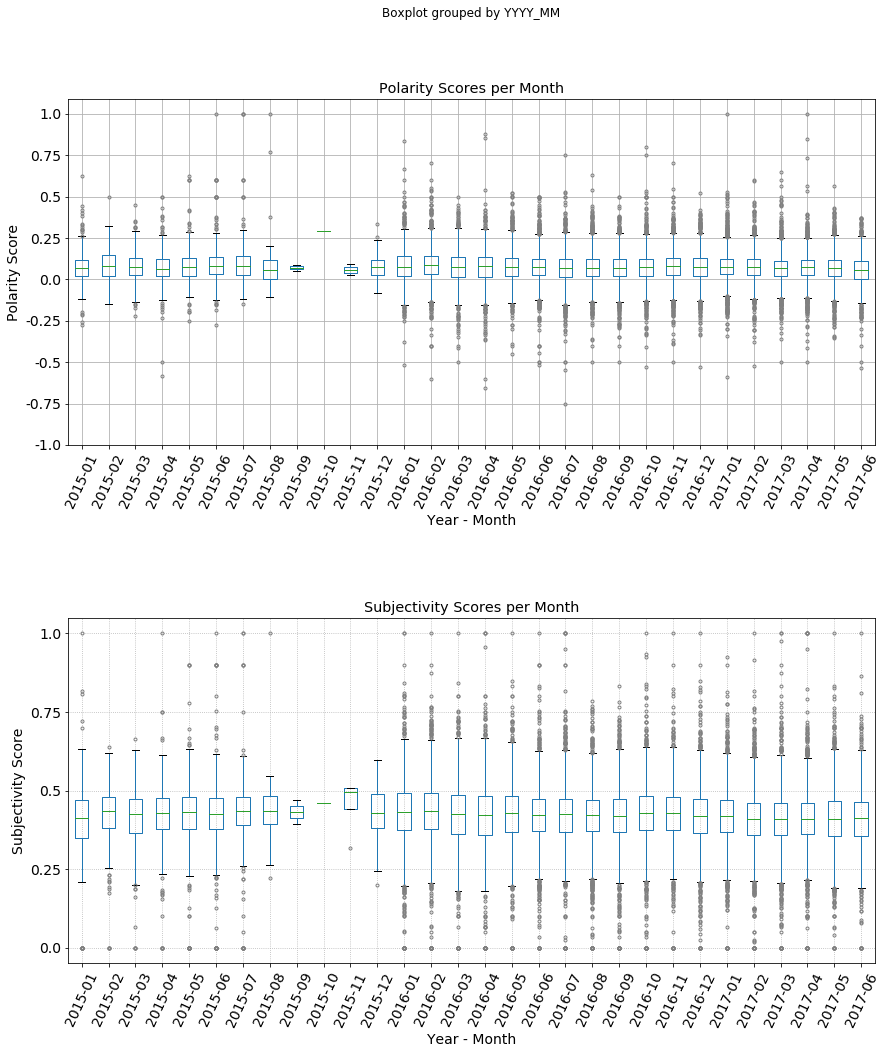

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False)
fig.set_size_inches(14, 16)
fig.subplots_adjust(hspace=.5)

yticks = [x / 100 for x in range(-100, 110, 25)]
yticklabels = [str(ytick) for ytick in yticks]

flierprops = dict(marker='o', markerfacecolor='none', markersize=3,
                  linestyle='none', markeredgecolor='grey')

sentiment_polarity_plot_args = {
    'fontsize' : 14,
    'ax' : axes[0],
    'rot' : 65,
    'by' : 'YYYY_MM',
    'flierprops' : flierprops,
}

sentiment_subjectivity_plot_args = {
    'fontsize' : 14,
    'ax' : axes[1],
    'rot' : 65,
    'by' : 'YYYY_MM',
    'flierprops' : flierprops,
}

sentiment_polarity_plot = sentiment_polarity.boxplot(**sentiment_polarity_plot_args)
# sentiment_polarity_plot = sentiment_polarity.boxplot(by='YYYY_MM', column=['polarity'])
sentiment_polarity_plot.set_title('Polarity Scores per Month')
sentiment_polarity_plot.set_xlabel('Year - Month', fontsize=14)
sentiment_polarity_plot.set_ylabel('Polarity Score', fontsize=14)
sentiment_polarity_plot.set_yticks([x / 100 for x in range(-100, 110, 25)])
sentiment_polarity_plot.set_yticklabels([str(x / 100) for x in range(-100, 110, 25)], fontsize=14)
# sentiment_polarity_plot.grid('on', which='both', linestyle=':')

sentiment_subjectivity_plot = sentiment_subjectivity.boxplot(**sentiment_subjectivity_plot_args)
sentiment_subjectivity_plot.set_title('Subjectivity Scores per Month')
sentiment_subjectivity_plot.set_xlabel('Year - Month', fontsize=14)
sentiment_subjectivity_plot.set_ylabel('Subjectivity Score', fontsize=14)
sentiment_subjectivity_plot.set_yticks([x / 100 for x in range(0, 110, 25)])
sentiment_subjectivity_plot.set_yticklabels([str(x / 100) for x in range(0, 110, 25)], fontsize=14)
sentiment_subjectivity_plot.grid('on', which='both', linestyle=':')


# sentiment_boxplot  sentiment_boxplot.boxplot(by='YYYY_MM', column=['polarity', 'subjectivity'])

[Back to Table of Contents](#toc)

## Cosine Similarity of News Articles' TFIDF

### Details of Cosine Similarity Analysis Step

##### Global Vectors (GloVe) for Word Representation
We choose a few keywords that relate to the company or type of companies we are trying to predict the stock of. In our project, we use a list of keywords that most closely describe technology companies. The keywords that we've chosen for this project are ('technology', 'phone', 'internet', 'security'). We create the word vector representation of these keywords and use this to find the cosine simliarity of the keywords to the vector representation of the TFIDFs that we've calculated.
<br>
<br>
We calculate the cosine similarity of the words taken from each article from the previous Sentiment-TFIDF step. This allows us to find the most related articles to our keywords vector.

##### Source
We utilized the 300 dimension word vectors from https://nlp.stanford.edu/data/ to calculate our cosine similarities. GloVe is an unsupervised machine learning algorithm for obtaining vector representations for words. GloVe was developed at Stanford as an open source project.

##### Functions used to calculate cosine similarity
We also created a class called CosineSimilarity that holds the functions needed to calculate cosine similaritis of individual words as well as lists of words.

In [25]:
class CosineSimilarity:

    def __init__(self, dim, glove_path=None):
        self.dim = dim
        self.df = None
        self.loadVectors(glove_path)

    def loadVectors(self, glove_path):
        """Loads in the glove vectors

        Args:
            glove_path (path): path to glove vectors file
        """
        if glove_path and os.path.exists(glove_path):
            self.df = pd.read_csv(glove_path,
                                header=None,
                                sep=' ',
                                quoting=csv.QUOTE_NONE
                                ).set_index(0)

    def cosine(self, A, B):
        """Computes the cosine similarity of vectors A and B

        Args:
            A (np.array): array 1
            B (np.array): array 2

        Returns:
            float : Cosine similarity of vectors A and B
        """

        dot_prod = sum(A * B)
        mag_A    = sqrt(sum(A * A))
        mag_B    = sqrt(sum(B * B))

        return dot_prod / (mag_A * mag_B)

    def sentence_to_vec(self, tokens):
        """Creates word vector from sentence

        Args:
            tokens (list(str)): list of tokens

        Returns:
            np.array: vector representation of tokens
        """
        if len(tokens) == 0:
            return None

        # step 1: lower all words
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        """
        step 2-3: look up word vectors for each token,
        compute the component-wise sum of the
        word vectors , and divide by num words
        """
        vec = np.zeros(self.dim)
        for token in tokens:
            try:
                vec += self.df.loc[token]
            except KeyError:
                pass

        vec /= len(tokens)

        return vec

    def cosFromWord(self, df, word):
        """Compute cosine similarities of words in df to word

        Args:
            df (pandas.DataFrame): DataFrame of words and their vectors
            word (str): word to find similarity of

        Returns:
            pandas.DataFrame: words in df and their cosine similarity to word
        """
        myvec     = array(df.loc[word])
        words     = df.index
        cos_words = list()
        for i in range(len(df)):
            # acquire the vector representation of the word
            vec = array(df.iloc[i])
            # calculate the cosine similarity
            cos_sim = self.cosine(myvec, vec)
            # append the cosine similarity of the word and the word siteself to the list
            cos_words.append([cos_sim, words[i]])

        # Transform the sorted_cos_words list to put it in the dataframe
        sorted_cos_words = sorted(cos_words)
        sorted_cos_words.reverse()
        sorted_cos_words = np.array(sorted_cos_words)
        sorted_cos_words = np.transpose(sorted_cos_words)

        # Create the dataframe
        cos_words_df = pd.DataFrame({
            'Cosine Similarity' : sorted_cos_words[0],
            'Word'              : sorted_cos_words[1]
        })

        return cos_words_df

    def cosFromVec(self, df, myvec):
        """Finds cosine similarity of words in df to myvec

        Args:
            df (pandas.DataFrame): DataFrame of words and their vectors
            myvec (np.array): vector to find similarity of

        Returns:
            pandas.DataFrame: words in df and their cosine similarity to myvec
        """
        words = df.index
        cos_words = list()
        for i in range(len(df)):
            # acquire the vector representation of the word
            vec = array(df.iloc[i])
            # calculate the cosine similarity
            cos_sim = cosine(myvec, vec)
            # append the cosine similarity of the word and the word siteself to the list
            cos_words.append([cos_sim, words[i]])

        # Transform the sorted_cos_words list to put it in the dataframe
        sorted_cos_words = sorted(cos_words)
        sorted_cos_words.reverse()
        sorted_cos_words = np.array(sorted_cos_words)
        sorted_cos_words = np.transpose(sorted_cos_words)
        # Create the dataframe
        cos_words_df = pd.DataFrame({
            'Cosine Similarity' :sorted_cos_words[0],
            'Word'              :sorted_cos_words[1]
        })

        return cos_words_df

In [ ]:
def cosine_similarity_news_articles(args):
    tokens, cos_sim, input_folder, output_folder, articles_name = args

    articles_path = os.path.join(input_folder, articles_name)
    output_path = os.path.join(output_folder, articles_name.replace('.json', '.csv'))

#     print('Analyzing {}'.format(articles_path))

    month_df = pd.DataFrame(columns=['date', 'year', 'month',
                                     'day', 'title',
                                     'polarity', 'subjectivity',
                                     'relatedness_title',
                                     'relatedness_content'])

    with open(articles_path) as f:
        try:
            month = json.load(f)
            month['data'].sort(key=lambda datum: datum['day'])
        except Exception:
            month_df.to_csv(output_path, index=False)
            print('Error in from {}'.format(articles_path))
            return

    vector_compare = cos_sim.sentence_to_vec(tokens)

    for data in month['data']:

        # Get list of tokens for tdidf and title
        tokens_tdidf = [tdidfs[0] for tdidfs in data['tdidf']]
        tokens_title = nltk.word_tokenize(data['title'])

        try:
            vector_tdidf = cos_sim.sentence_to_vec(tokens_tdidf)
            cos_title = cos_sim.cosine(vector_tdidf, vector_compare)
        except Exception:
            cos_title = 0.0

        try:
            vector_title = cos_sim.sentence_to_vec(tokens_title)
            cos_tdidf = cos_sim.cosine(vector_title, vector_compare)
        except Exception:
            cos_tdidf = 0.0

        day_data = {
            'date'                : ['{Y}-{M:02}-{D:02}'.format(Y=int(data['year']), M=int(data['month']), D=int(data['day']))],
            'year'                : [data['year']],
            'month'               : [data['month']],
            'day'                 : [data['day']],
            'title'               : [data['title']],
            'subjectivity'        : [data['subjectivity']],
            'polarity'            : [data['polarity']],
            'relatedness_title'   : [cos_title],
            'relatedness_content' : [cos_tdidf]
        }
        day_df = pd.DataFrame.from_dict(day_data)
        month_df = month_df.append(day_df)

    month_df = month_df.reset_index(drop=True)
    month_df.to_csv(output_path, index=False)

#     print('Finished analyzing {} with {} results'.format(articles_path, len(month_df)))
#     print(output_path)
    return

In [ ]:
input_folder = 'data/tfidf/all-the-news/'
dim = 300
output_folder = 'data/cosineSimilarity/all-the-news/dim{dim}_1'.format(dim=dim)
vector_model_path = 'glove.6B/glove.6B.{dim}d.txt'.format(dim=dim)

try:
    os.mkdirs(input_folder, exist_ok=True)
except:
    pass

try:
    os.mkdir(output_folder)
except:
    pass

articles_names = glob(os.path.join(input_folder, 'articles_2016*'))

<div class="alert alert-block alert-success">
<b>Keywords we're using to generally describe technology companies such as Amazon: 'technology', 'phone', 'internet', 'security'</b>
</div>

In [ ]:
tokens = ['technology', 'phone', 'internet', 'security']
cos_sim = CosineSimilarity(dim, glove_path=vector_model_path)

arguments = [(tokens, cos_sim, input_folder, 
              output_folder, os.path.basename(articles_name)) for articles_name in articles_names]

<div class="alert alert-block alert-danger">
<b>Notice:</b> We turned the cell below to markdown so we do not accidentally run it again, as it takes a very long time to run.
</div>

```python
print('Starting analysis')
sc = pyspark.SparkContext(appName='News Articles')
process_cosine_by_month = sc.parallelize(arguments, len(arguments)).map(cosine_similarity_news_articles)
collect_cosine_by_month = process_cosine_by_month.collect()
sc.stop()
print('Finished analysis')
```

[Back to Table of Contents](#toc)

### Let's Explore the Preprocessed News Article Data

We will look at the cosine similarities of all articles for every month. This will not only give us a general idea of how often news articles talk about technology, but it'll tell us much of our data can be used to give an accurate representation of the sentiment towards technology in general!

In the box plots below, we observe that the mean cosine similarity between the content of news articles and the keywords that we've chosen hover close to 0.5 for every month in 2016. This tells us that the variability on a month to month basis is low.

#### Interesting Observation: 
We wanted to dig deeper into the news articles, so we made barplots for the cosine similarity everyday in November 2016. The reason why we do this is because **Black Friday** and **Cyber Monday** are both in November. We observe that the days leading up to Black Friday, the mean cosine similarity between news articles and the keywords we've chosen stays the same. However, during that one weekend after Thanksgiving, the mean cosine similarity goes down and jumps back up right on Cyber Monday.

In [17]:
input_folder = 'data/cosineSimilarity/all-the-news/dim300_1'
Y = '2016'
M = '*'

regex_names = 'articles_{Y}_{M}.csv'.format(Y=Y, M=M)
regex_paths = os.path.join(input_folder, regex_names)

articles_names = glob(regex_paths)

output_name = 'max_articles_{Y}_1.csv'.format(Y=Y)
output_path = os.path.join(input_folder, output_name)

In [18]:
months_similarity_df = pd.DataFrame(columns=['date', 'year', 'month',
                           'day', 'title',
                           'polarity', 'subjectivity',
                           'relatedness_title',
                           'relatedness_content'])

for articles_name in articles_names:
    
    month_similarity_df = pd.read_csv(articles_name)
    
    months_similarity_df = months_similarity_df.append(month_similarity_df)

months_similarity_df = months_similarity_df.reset_index(drop=True)
months_similarity_df['YYYY_MM'] = months_similarity_df.apply(lambda row: row.date[:7], axis=1)

In [19]:
relatedness_content_df = months_similarity_df.drop(columns=['title', 'year', 'month', 
                                                      'day', 'polarity', 'subjectivity', 
                                                      'date', 'relatedness_title'])
relatedness_title_df = months_similarity_df.drop(columns=['title', 'year', 'month', 
                                                      'day', 'polarity', 'subjectivity', 
                                                      'date', 'relatedness_content'])
relatedness_content_month_df = months_similarity_df.where(months_similarity_df.month == 11)\
                                                     .dropna().reset_index(drop=True) \
                                                     .drop(columns=['title', 'YYYY_MM', 'month', 'year',
                                                                    'polarity', 'subjectivity', 
                                                                    'date', 'relatedness_title'])   

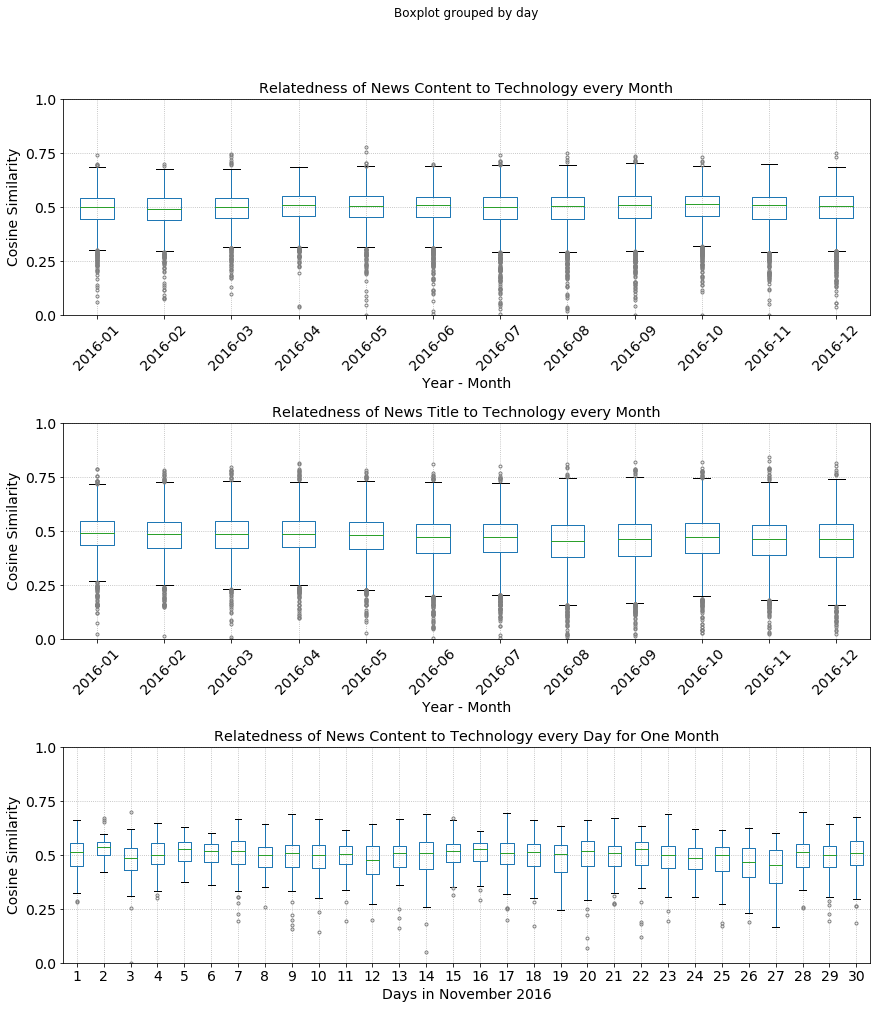

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False)
fig.set_size_inches(14, 16)
fig.subplots_adjust(hspace=.5)

yticks = [x / 100 for x in range(0, 110, 25)]
yticklabels = [str(ytick) for ytick in yticks]

flierprops = dict(marker='o', markerfacecolor='none', markersize=3,
                  linestyle='none', markeredgecolor='grey')

relatedness_content_plot_args = {
    'fontsize' : 14,
    'ax' : axes[0],
    'rot' : 45,
    'by' : 'YYYY_MM',
    'flierprops' : flierprops,
}

relatedness_title_plot_args = {
    'fontsize' : 14,
    'ax' : axes[1],
    'rot' : 45,
    'by' : 'YYYY_MM',
    'flierprops' : flierprops,
}

relatedness_content_month_plot_args = {
    'fontsize' : 14,
    'ax' : axes[2],
    'rot' : 0,
    'by' : 'day',
    'flierprops' : flierprops,
}

relatedness_content_plot = relatedness_content_df.boxplot(**relatedness_content_plot_args)
relatedness_content_plot.set_title('Relatedness of News Content to Technology every Month')
relatedness_content_plot.set_xlabel('Year - Month', fontsize=14)
relatedness_content_plot.set_ylabel('Cosine Similarity', fontsize=14)
relatedness_content_plot.set_yticks(yticks)
relatedness_content_plot.set_yticklabels(yticklabels, fontsize=14)
relatedness_content_plot.set_ylim(ymin=0, ymax=1)
relatedness_content_plot.grid('on', which='both', linestyle=':')

relatedness_title_plot = relatedness_title_df.boxplot(**relatedness_title_plot_args)
relatedness_title_plot.set_title('Relatedness of News Title to Technology every Month')
relatedness_title_plot.set_xlabel('Year - Month', fontsize=14)
relatedness_title_plot.set_ylabel('Cosine Similarity', fontsize=14)
relatedness_title_plot.set_yticks(yticks)
relatedness_title_plot.set_yticklabels(yticklabels, fontsize=14)
relatedness_title_plot.set_ylim(ymin=0, ymax=1)
relatedness_title_plot.grid('on', which='both', linestyle=':')

relatedness_content_month_plot = relatedness_content_month_df.boxplot(**relatedness_content_month_plot_args)
relatedness_content_month_plot.set_title('Relatedness of News Content to Technology every Day for One Month')
relatedness_content_month_plot.set_xlabel('Days in November 2016', fontsize=14)
relatedness_content_month_plot.set_ylabel('Cosine Similarity', fontsize=14)
relatedness_content_month_plot.set_yticks(yticks)
relatedness_content_month_plot.set_yticklabels(yticklabels, fontsize=14)
relatedness_content_month_plot.set_ylim(ymin=0, ymax=1)
relatedness_content_month_plot.grid('on', which='both', linestyle=':')

[Back to Table of Contents](#toc)

### Final Output of News Article Dataset and Sanity Check, Too

As an input to the model, we pick out the article with the highest relatedness_content (cosine similarity) for each day in 2016. We use the sentiment from these articles to create our model. 

As a sanity check, we look at the titles and news articles with the highest relatedness_content, and check to see that the title of the article is close to what we expect. We choose to check by looking at the titles, because reading through each and every article would be a very time-consuming process.

In [23]:
max_df = pd.DataFrame(columns=['date', 'year', 'month',
                           'day', 'title',
                           'relatedness_title',
                           'relatedness_content'])

for articles_name in articles_names:
    
    month_df = pd.read_csv(articles_name)

    for day in range(1, 31+1):
        day_df = month_df.where((month_df.day == day)).dropna().reset_index(drop=True)

        max_day_df = day_df.sort_values('relatedness_content', ascending=False).drop_duplicates('month')

        max_df = max_df.append(max_day_df)
        
        max_df['YYYY_MM'] = max_df.apply(lambda row: row.date[:7], axis=1)
        
max_df = max_df.sort_values(['relatedness_content'], ascending=False).reset_index(drop=True)

In [24]:
max_df.head(5)

,YYYY_MM,date,day,month,polarity,relatedness_content,relatedness_title,subjectivity,title,year
0,2016-05,2016-05-20,20.0,5.0,0.098057,0.778007,0.730242,0.520628,New Surveillance Technology Allows Cops to Tap...,2016.0
1,2016-05,2016-05-24,24.0,5.0,0.153535,0.754311,0.677163,0.366414,Expert Warns Facebook Could Be Eavesdropping T...,2016.0
2,2016-08,2016-08-26,26.0,8.0,0.121275,0.750116,0.807067,0.440659,IPhone Users Urged to Update Software After Se...,2016.0
3,2016-12,2016-12-03,3.0,12.0,-0.051587,0.747588,0.656304,0.328968,Trump deputy national security pick scrubs her...,2016.0
4,2016-03,2016-03-14,14.0,3.0,0.194456,0.745430,0.661342,0.478324,New Tool Helps Users Determine What Personal D...,2016.0


### Digging Deeper into the Articles with the Highest Cosine Similarity per Day
We can also look at how the **polarity** and **subjectivity** scores for the articles with the highest relatedness_content or Cosine Similarity scores fare. 

In the graphs below, we see that the average polarity scores hover right about 0, indicating that is neutral but the news on technology companies are shifted more towards the positive end. Also, the average subjectivity score sits right below 0.5, indicating that news articles are partly subjective and not fully objective.

These results are consistent with the average polarity and subjectivity scores for articles with any relatedness_content or Cosine Similarity score.

In [25]:
max_polarity_df = max_df[['polarity', 'YYYY_MM']]
max_subjectivity_df = max_df[[ 'subjectivity', 'YYYY_MM']]

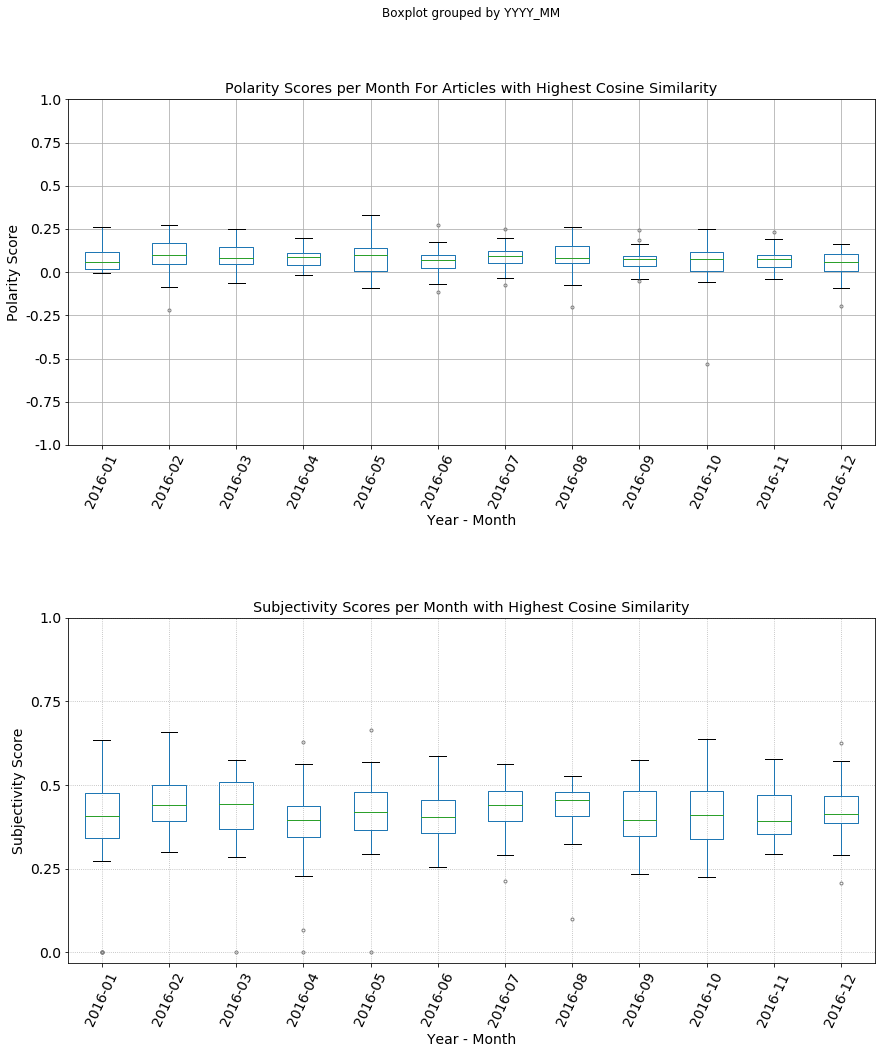

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False)
fig.set_size_inches(14, 16)
fig.subplots_adjust(hspace=.5)

yticks = [x / 100 for x in range(-100, 110, 25)]
yticklabels = [str(ytick) for ytick in yticks]

flierprops = dict(marker='o', markerfacecolor='none', markersize=3,
                  linestyle='none', markeredgecolor='grey')

max_polarity_plot_args = {
    'fontsize' : 14,
    'ax' : axes[0],
    'rot' : 65,
    'by' : 'YYYY_MM',
    'flierprops' : flierprops,
}

max_subjectivity_plot_args = {
    'fontsize' : 14,
    'ax' : axes[1],
    'rot' : 65,
    'by' : 'YYYY_MM',
    'flierprops' : flierprops,
}

max_polarity_plot = max_polarity_df.boxplot(**max_polarity_plot_args)
max_polarity_plot.set_title('Polarity Scores per Month For Articles with Highest Cosine Similarity')
max_polarity_plot.set_xlabel('Year - Month', fontsize=14)
max_polarity_plot.set_ylabel('Polarity Score', fontsize=14)
max_polarity_plot.set_yticks([x / 100 for x in range(-100, 110, 25)])
max_polarity_plot.set_yticklabels([str(x / 100) for x in range(-100, 110, 25)], fontsize=14)
# max_polarity_plot.grid('on', which='both', linestyle=':')

max_subjectivity_plot = max_subjectivity_df.boxplot(**max_subjectivity_plot_args)
max_subjectivity_plot.set_title('Subjectivity Scores per Month with Highest Cosine Similarity')
max_subjectivity_plot.set_xlabel('Year - Month', fontsize=14)
max_subjectivity_plot.set_ylabel('Subjectivity Score', fontsize=14)
max_subjectivity_plot.set_yticks([x / 100 for x in range(0, 110, 25)])
max_subjectivity_plot.set_yticklabels([str(x / 100) for x in range(0, 110, 25)], fontsize=14)
max_subjectivity_plot.grid('on', which='both', linestyle=':')

[Back to Table of Contents](#toc)

<a id="toc2b"></a>
# Data Exploration -  Wikipedia

We used the Wikipedia in order assess the online web traffic. The dataset contains over 145063 articles with its traffic number from 2015 to 2016 which is over 550 columns of data for every column. We used pandas library to handle all the data manipulation. 


Exploration, can we find some pattern in the underlying website traffic dataset?


After flattening the data, by filtering and really "massaging" the data we were able to a clean the dataset. As there were duplicate articles we were able to group and take the mean of the visitor for a page for a particular day. 

We wanted to experiment with just predicting the number of views a Wikipedia page gets in the future, we thought it would be interesting to find out regarding this topic due to its application web traffic monitoring, if we think an anomaly is going to happen by looking one step further we can actually be ready for such event in time of** higher traffic for a website, making the website more robust.

**Moving Average**
<br>
We started off with the naive method which relied on y(t+1) = y(t), as it a naive solution its not the most accurate, and we can see in the graph below. Then other methods we experimented with were an average of entire graph which lead to prediction that were really off, then we use rolling mean with window of n variables in the past that gave a better estimate as you can see that below. 

**Exponential Smoothing**
<br>
Later used which weighted the data point weaker as we further away from those points. Lastly, with the help Holts trend, we wanted to see if we could find any trend with our data. We graphed the Trend, Seasonality and Residual below and if there is a particular trend seen in the dataset we can use the holt winter method, however we weren’t able o see any particular trend but we saw a pattern in seasonality and so we carried on to the most popular method which is the Sarima. Sarima aka Seasonal Autoregressive Integrated Moving average where we saw closeness to the dataset

#### Load Wikipedia Data

In [27]:
train = pd.read_csv("input/wikipedia/train_1.csv")
df = train
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


**As we were concerned with a company's traffic flow we narrowed our search to the articles that were related with amazon. We found amazon.com in few languages  on multiple platform,  as the data wasnt the desired shape, we reshaped the data according to our desire and tired if we could find any interesting thigns about the amazon articles or articles in general, in the beginning we were unsure what question to ask, so we asked questions like which languages had the highest traffic flow, which days of the week or the month had the most traffic, as its a timeseries it was one of the first things that came to mind. **

In [28]:
companyName = "Amazon.com"
df = train[train['Page'].str.contains(companyName)]
train = df
train_flattened = pd.melt(train[list(train.columns[-550:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

**Which spoken language has the highest traffic?**
As expected english was the langauge visited the most, which was expected however the other languages that had information regarding the company amazon were the following German, French, Japaneese. We couldnt seem to figure out why only these languages were listed for amazon.com wikipedia pages. However we see an interesting spike in wikipedia amazon.com visits in german for 2016, I think the reason for that could the set up for the biggest piano maker in the german bought by china and as a result they might be interested in e-commerce what better way to do e-commerce than Amazon. The company is really huge and as it is the biggest manufactuer and supplier of piano I think its an interesting peak to see in the dataset. Other events that coorelated with such event was the world luge competition and due to an increased traffic in the area we could see how that might have created a wierd peak in our graph.

Text(0.5,1,'Daily Avg. Wikipedia Article Views vs. Languages')

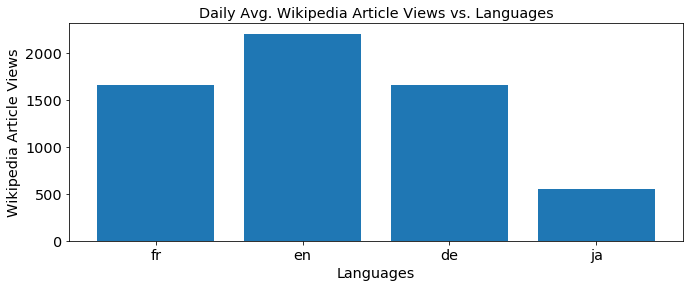

In [29]:
plt.figure(figsize=(11, 4))

def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train_flattened["language"] = train_flattened.Page.map(get_language)
D = Counter(train_flattened.language)

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.xlabel('Languages')
plt.ylabel('Wikipedia Article Views')
plt.title('Daily Avg. Wikipedia Article Views vs. Languages')

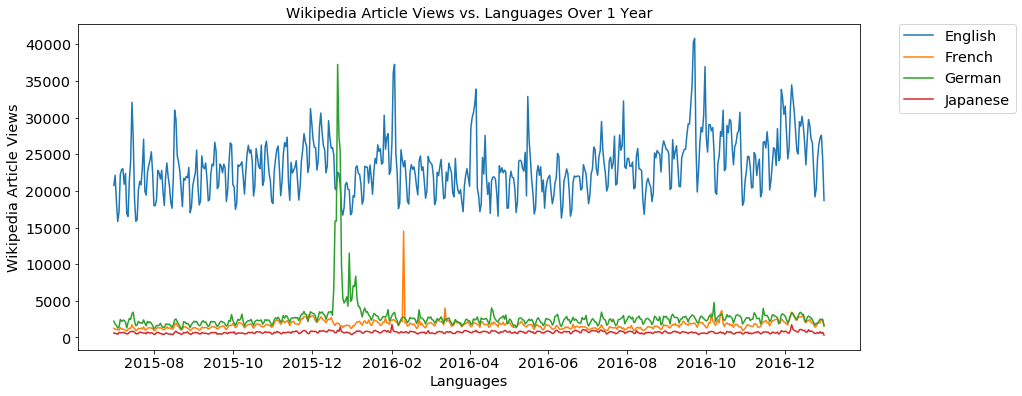

In [30]:
english = train_flattened[train_flattened["language"] == "en"].groupby("date").agg({'Visits':'sum'})
french = train_flattened[train_flattened["language"] == "fr"].groupby("date").agg({'Visits':'sum'})
de = train_flattened[train_flattened["language"] == "de"].groupby("date").agg({'Visits':'sum'})
ja = train_flattened[train_flattened["language"] == "ja"].groupby("date").agg({'Visits':'sum'})
                                             
plt.figure(figsize=(14, 6))
plt.plot(english, label="English")
plt.plot(french, label="French")
plt.plot(de, label="German")
plt.plot(ja, label = "Japanese")
plt.xlabel('Languages')
plt.ylabel('Wikipedia Article Views')
plt.title('Wikipedia Article Views vs. Languages Over 1 Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [31]:
# =======================================================
# Median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

# Average by page
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

# Merging data
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)
train_flattened.reset_index(drop=False,inplace=True)
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())
train_flattened['year']=train_flattened.date.dt.year 
train_flattened['month']=train_flattened.date.dt.month 
train_flattened['day']=train_flattened.date.dt.day
train_flattened["Visits"] = train_flattened["Visits"].fillna(0)

**The time series data is showed for wikipedia for entriety of the dataset, we can see vaguely see trends in the web traffic and how it spans out for the 2015 - 2016**

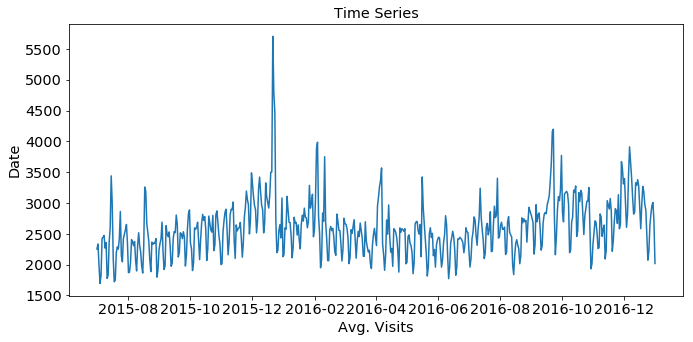

In [32]:
plt.figure(figsize=(11, 5))
mean_group_copy = train_flattened
mean_group_copy["Date"] = train_flattened["date"]
mean_group_copy = mean_group_copy[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.xlabel('Avg. Visits')
plt.ylabel('Date')
plt.title('Time Series')
plt.show()

In [33]:
#=========================HEATMAP=========================
train_flattened['month_num'] = train_flattened['month']
train_flattened['month'].replace('11','11 - November',inplace=True)
train_flattened['month'].replace('12','12 - December',inplace=True)
train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)
#========================trainging dataset=================
train_group = train_flattened.groupby(["month", "weekday"])['Visits'].mean().reset_index()
train_group = train_group.pivot('weekday','month','Visits')
train_group.sort_index(inplace=True)

**We thought this heatmap was really interesting, prior use of  a tradition bar graph did not do justice to the acurate representation of the visit frequency on tha pages over week and month. The darker colors mean that there was more traffic on those days while the ligher shade shows how the traffic decreases on those days. We can also see how the weekends were loosely populated which makes sense as most people are mostly done working, which coorelates with in general with how many work during the weekday vs how many people are free on weekends to browse the web**

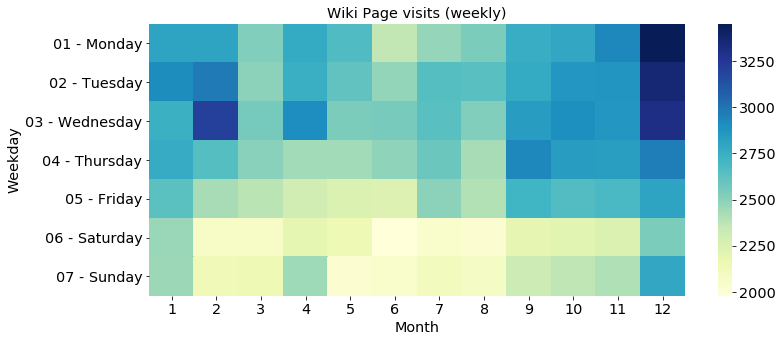

In [34]:
f, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(train_group, annot=False, ax=ax, fmt=".2g", cmap="YlGnBu")
plt.xlabel('Month')
plt.ylabel('Weekday')
plt.title('Wiki Page visits (weekly)')
plt.show()

**How to get that data? and what data to use that would be later be sufficient for feature engineering for our ML and deep learning dataset and what challenges we faced**
<br>
<br>
We experimented with couple of dataset and different ways to aggregate data. Finding the right dataset was one of the biggest problem as deciding in the beginning that we would like to use a dataset without experimenting was impossible. We looked Facebook’s graph API and twitters API, as we wanted to our sentiment from social networks. However, due to Facebooks recent change in graph API and ongoing law suites, if made it much harder for us to get access. Twitter access was straight forward however the length of the data through the ape was restricted to 1 week. As a result, we resorted to using dataset that were available from kaggle. We used a new articles dataset that had new articles for all of 2016 which made it easier to get sentiment on a topic. And we to use decided Wikipedia dataset which replicated web traffic for a subject as most of the searches lead to Wikipedia as first option in google search. 

In [35]:
df = train_flattened
df = df.set_index('date')
df = df[['Page','Visits']]

In [36]:
start_date  = '2016-01-01'
end_date    = '2016-10-31'

start_date_test = '2016-11-01'
end_date_test = '2016-12-31'

train = df
Train = df.ix[start_date:end_date]
valid = df.ix[start_date_test: end_date_test]
test = df.ix[start_date_test: end_date_test]
Train  = Train.groupby(['date']).sum()
test = test.groupby(['date']).sum()

Text(0.5,1,'Naive Forecast')

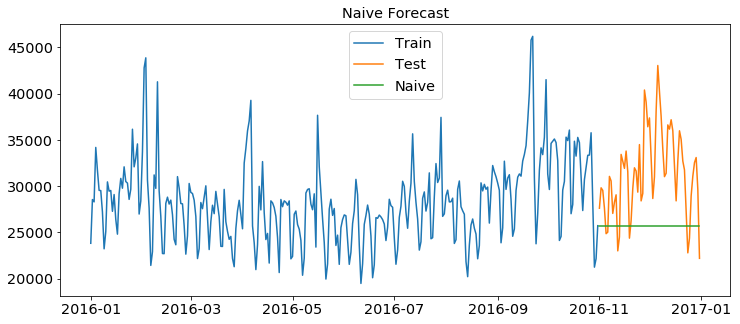

In [37]:
#========================================NAIVE==================================================
dd = np.asarray(Train.Visits)
y_hat =test.copy()
y_hat['naive']= dd[len(dd)- 1]
plt.figure(figsize = (12,5))
plt.plot(Train.index, Train['Visits'],label = 'Train')
plt.plot(test.index, test['Visits'], label = 'Test')
plt.plot(y_hat.index, y_hat['naive'],  label = 'Naive')
plt.legend(loc = 'best')
plt.title('Naive Forecast')

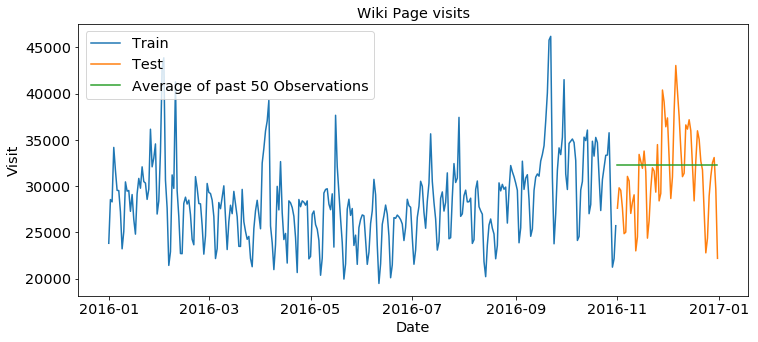

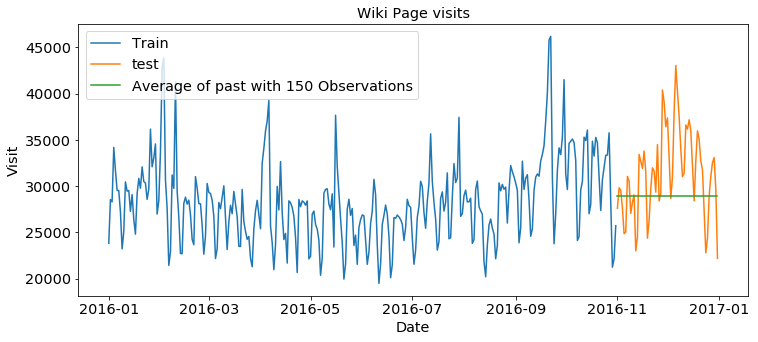

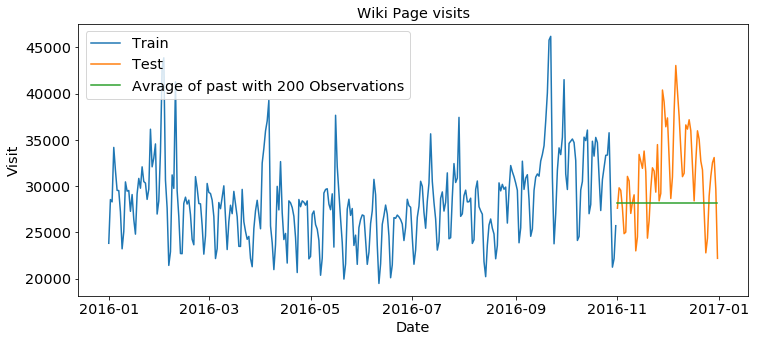

In [38]:
#========================================Moving Average==================================================

y_hat_avg = test.copy()
y_hat["50 prev observation"] = Train['Visits'].rolling(50).mean().iloc[-1]

y_hat['150 prev observation'] = Train['Visits'].rolling(150).mean().iloc[-1]
y_hat['200 prev observation'] = Train['Visits'].rolling(200).mean().iloc[-1]

plt.figure(figsize = (12,5))
plt.plot(Train['Visits'], label = 'Train')
plt.plot(test['Visits'], label = 'Test')
plt.plot(y_hat["50 prev observation"], label = 'Average of past 50 Observations')
plt.legend(loc = 'best')
plt.xlabel('Date')
plt.ylabel('Visit')
plt.title('Wiki Page visits')
plt.show()

plt.figure(figsize = (12,5))
plt.plot(Train['Visits'], label = 'Train')
plt.plot(test['Visits'], label = 'test')
plt.plot(y_hat["150 prev observation"], label = 'Average of past with 150 Observations')
plt.legend(loc = 'best')
plt.xlabel('Date')
plt.ylabel('Visit')
plt.title('Wiki Page visits')
plt.show()

plt.figure(figsize = (12,5))
plt.plot(Train['Visits'], label = 'Train')
plt.plot(test['Visits'], label = 'Test')
plt.plot(y_hat["200 prev observation"], label = 'Avrage of past with 200 Observations')
plt.legend(loc = 'best')
plt.xlabel('Date')
plt.ylabel('Visit')
plt.title('Wiki Page visits')
plt.show()


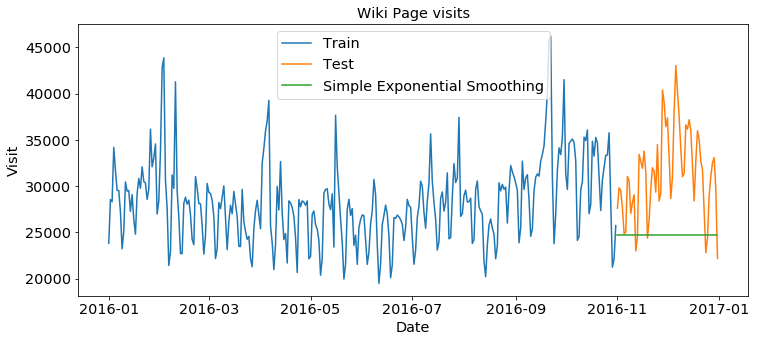

In [39]:
#========================================Exponenetial smoothing with alpha==================================================

fit2 = SimpleExpSmoothing(np.asarray(Train['Visits'])).fit(smoothing_level = 0.6,optimized = False)
y_hat['ExpSmoothing'] = fit2.forecast(len(test))
plt.figure(figsize =(12,5))
plt.plot(Train['Visits'], label = 'Train')
plt.plot(test['Visits'], label = 'Test')
plt.plot(y_hat['ExpSmoothing'], label = 'Simple Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Visit')
plt.title('Wiki Page visits')
plt.legend(loc = 'best')


Holt's Linear Trend Model
Used to show the overarching theme, behind the data we provided

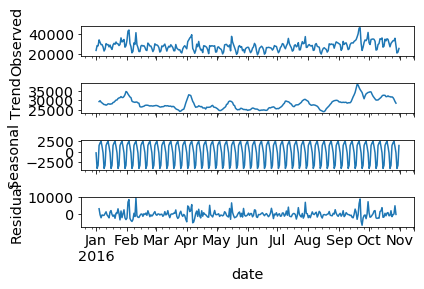

In [45]:
#========================================Trend & seasonality ==================================================
train_visits_plot = sm.tsa.seasonal_decompose(Train.Visits).plot()
result = sm.tsa.stattools.adfuller(train.Visits)
plt.xlabel('Date')
plt.show()

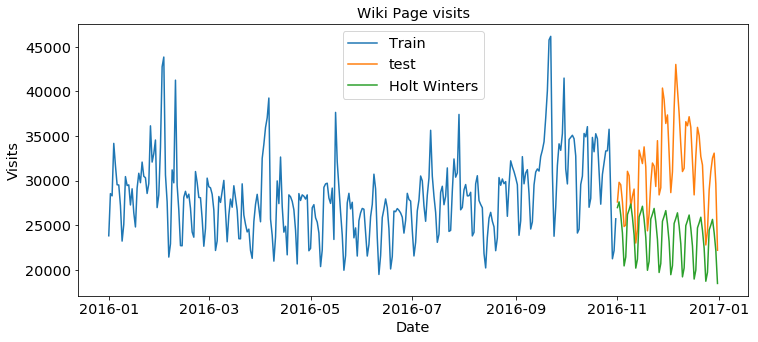

In [41]:
#========================================HOLT winter Model==================================================
fit1 = ExponentialSmoothing(np.asarray(Train['Visits']), seasonal_periods= 7, trend = 'add', seasonal= 'add').fit()
y_hat['HW'] = fit1.forecast(len(test))
plt.figure(figsize = (12,5))
plt.plot(Train['Visits'], label = 'Train')
plt.plot(test['Visits'], label = 'test')
plt.plot(y_hat["HW"], label = 'Holt Winters')
plt.legend(loc = 'best')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.title('Wiki Page visits')
plt.show()

Text(0.5,1,'SARIMAX Model')

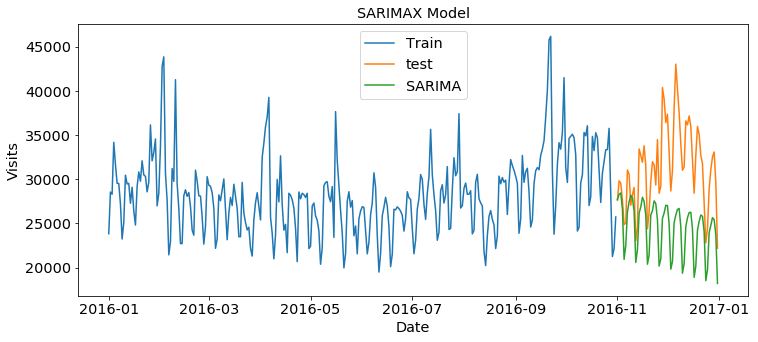

In [42]:

#========================================SARIMA==================================================
fit1 = sm.tsa.statespace.SARIMAX(Train.Visits, order = (2,1,4), seasonal_order =(0,1,1,7)).fit()
y_hat['SARIMA'] = fit1.predict(start=start_date_test, end= end_date_test, dynamic=True)
plt.figure(figsize=(12,5))
plt.plot(Train['Visits'], label = "Train")
plt.plot(test.Visits, label = "test")
plt.plot(y_hat['SARIMA'], label ="SARIMA")
plt.legend(loc = "best")
plt.xlabel('Date')
plt.ylabel('Visits')
plt.title("SARIMAX Model")

Text(0,0.5,'Error Score')

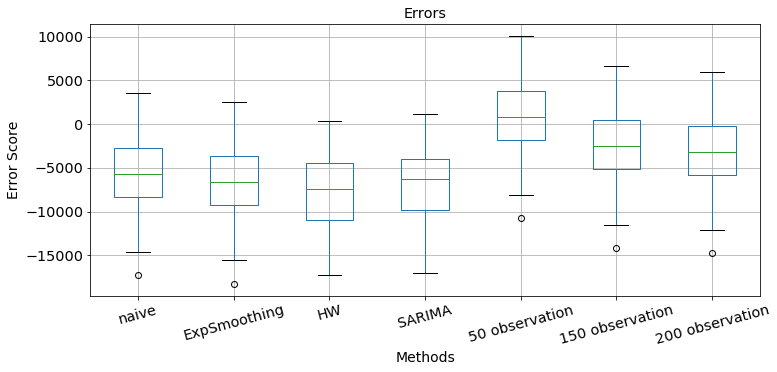

In [46]:
#===================Errors from above===================
#error = y_hat.copy()
error = y_hat.drop(columns = "Visits").copy()
error["naive"] = y_hat["naive"] - test["Visits"]
error["50 observation"] = y_hat["50 prev observation"] - test["Visits"]
error["150 observation"] = y_hat["150 prev observation"] - test["Visits"]
error["200 observation"] = y_hat["200 prev observation"] - test["Visits"]
error["ExpSmoothing"] = y_hat["ExpSmoothing"] - test["Visits"]
error["HW"] = y_hat["HW"] - test["Visits"]
error["SARIMA"] = y_hat["SARIMA"] - test["Visits"]
error = error.drop(columns = "50 prev observation").copy()
error = error.drop(columns = "150 prev observation").copy()
error = error.drop(columns = "200 prev observation").copy()
error_boxplot = error.boxplot(rot=15, figsize=(12,5))

error_boxplot.set_title('Errors')
error_boxplot.set_xlabel('Methods', fontsize=14)
error_boxplot.set_ylabel('Error Score', fontsize=14)

**So what did we find about the wikipedia data?**

Holts Winter and SARIMA, both are widely used for time series datasets. As we can clearly see that these two aglo had actually closest similiarity out of all the other algo we used. It was able to show a seasonality element in its prediction. However, the most important result was the finding of seasonal trend in our dataset. 

So did we find anything interesting about the wikipedia data? Our aim was to find if there is a pattern in the way people access these articles. In this case as we were looking at Amazom.com article we saw how there is a seasonality element with the articles. Meaning it follows an increasing and decreasing number of views. After a certain time the amazon articles follows a upwards or downwards trend. We can see that in the seasonality graph and also, with past 50 moving average we see we yield the lowest the error and this makes sense as the views of the next days depends on wehther views traffic was slower or fast in the past. 

However the SARIMA model was able to depict the model trend quite accuratly. As we now know that there is a coorelation between past and future data, we can use this data successfully to find coorelation between stock data and see if there is a significnat trend between the two.

### Data Manipulation and exploration

<div class="alert alert-block alert-warning">
<b>Amazon & News Sentiment & Wikipedia Visits --</b> Refer above to how we preprocessed each dataset. 
</div>

In the next few steps we are further cleaning up the remaining dataset, we are setting it up for the right features and organizing in a time series manner so it easy to apply machine learning and deep learning algorithms.

What range/time frame for our data? what is the size of the dataset? Due to limited availability of the Wikipedia data we decided to look for the data for 2016. The Wikipedia and sentiment dataset comes out to be with 365 entries that is once for each day, however due to national holidays and weekends the stock data comes out to be about only 250 values. Thus, we find a way to merge these three datasets. We learned about join works. They are typically used for in relational databases, and how they work is if two databases are connected to each with common columns you can "join" them into one dataset. There are few ways of working out a join, inner, outer, right, left. We used inner join because we wanted to drop the dates (rows) that didn’t exist in the amazon dataset. So, join the three datasets on dates ended up giving the master dataset that we used for the remainder of the ML and deep learning

Normalizing - This is one of the biggest as the results before we applied normalization did not provide any accurate results. After we dug a little deeper and found that trying to train a dataset without prepping is never a good idea. So, learned about normalization, we found a couple of ways to normalize, but ended up deciding on subtracting every number by its mean and dividing by the standard deviation in order to preprocess our data and give us a much cleaner dataset. While researching we found it is important to normalize or scale the dataset especially when you are using features vectors with different units and as we are doing that it sit perfectly with the normalization we carried out.

Feature engineering - This is a really crucial part as it determines if you model is good or bad. We tried to come with as good and appropriate features as possible. For this we referenced few articles and websites mentioned below. For amazon dataset, we took a rolling average of the past 5, 10 and 15 days as there could be a relation to how the market has been doing recently. We added the difference in closed and open price and low and high as our features. We also shifted our features by a row as a result we are using yesterday’s results to predict tomorrows results.

[Back to Table of Contents](#toc)

<a id="toc3"></a>
# 3. Training Models Using<br><br>Amazon Financial Data,<br> Wikipedia Visits, and<br>Sentiment on News Articles

## Metrics Used to Compare Regression Models

<div class="alert alert-block alert-info">
<b>Explained Variance:</b> 
<br>    
measures the proportion to which a mathematical model accounts for the variation (dispersion) of a given data set. 
</div>

In [47]:
from sklearn.metrics import explained_variance_score

<div class="alert alert-block alert-info">
<b>Mean Absolute Error:</b>
<br>
measure of difference between two continuous variables
</div>

In [131]:
from sklearn.metrics import mean_absolute_error

<div class="alert alert-block alert-info">
<b>Mean Squared Error:</b> values closer to 0 are better
<br>    
expected value of the squared error loss. Measured quality of estimator. More stable than MAE (above)
</div>

In [49]:
from sklearn.metrics import mean_squared_error

<div class="alert alert-block alert-info">
<b>Median Absolute Error:</b>
<br>    
is robust to outliers. The loss is calculated by taking the median of all absolute differences between the target and the prediction.
</div>

In [51]:
from sklearn.metrics import median_absolute_error

<div class="alert alert-block alert-info">
<b>R2:</b> range of [0, 1], values closer to 1 are better
<br>
provides a measure of how well future samples are likely to be predicted by the model. Best possible score is 1.0 and it can be negative 
</div>

In [52]:
from sklearn.metrics import r2_score

In [112]:
ML_SVR_RBF = 'SVR - RBF'
ML_SVR_LINEAR = 'SVR - Linear'
DL_NEURAL_NET = 'Neutral Network'
DATASET_AMZN = 'Amazon Finance'
DATASET_AMZN_WIKI = 'Amazon Finance + Wikipedia Visits'
DATASET_AMZN_SENT = 'Amazon Finance + News Article Sentiments'
DATASET_COMBINED = 'Amazon Finance + Wikipedia Visits + News Article Sentiments'

def get_model_metrics(y_true, y_pred, model_type, dataset_type):
    metrics = dict()
    metrics['Model'] = model_type
    metrics['Dataset'] = dataset_type
    
    try:
        metrics['Explained Variance Score'] = [explained_variance_score(y_true, y_pred)]
    except Exception:
        metrics['Explained Variance Score'] = [None]
    try:
        metrics['Mean Absolute Error'     ] = [mean_absolute_error     (y_true, y_pred)]
    except Exception:
        metrics['Mean Absolute Error'     ] = [None]
    try:
        metrics['Mean Squared Error'      ] = [mean_squared_error      (y_true, y_pred)]
    except Exception:
        metrics['Mean Squared Error'      ] = [None]
    try:
        metrics['Median Absolute Error'   ] = [median_absolute_error   (y_true, y_pred)]
    except Exception:
        metrics['Median Absolute Error'   ] = [None]
    try:
        metrics['R2 Score'                ] = [r2_score                (y_true, y_pred)]
    except Exception:
        metrics['R2 Score'                ] = [None]
    return metrics

#### Load in the Amazon Finance Dataset

In [54]:
upper = pd.Timestamp(2016, 12, 31)
low   =  pd.Timestamp(2016, 1, 1)
dataset_amazon = pd.read_csv("input/amazon/AMZN.csv")
dataset_amazon = dataset_amazon[["Date", "Open", "Adj. Open", "Close", "High", "Low"]]
dataset_amazon['Date'] = pd.to_datetime(dataset_amazon['Date'])
dataset_amazon["Year"] = pd.DatetimeIndex(dataset_amazon['Date']).year
dataset_amazon["Month"] = pd.DatetimeIndex(dataset_amazon['Date']).month
dataset_amazon["Day"]  = pd.DatetimeIndex(dataset_amazon['Date']).day
filter_mask = dataset_amazon['Date'] <= upper 
filter_mask2 = dataset_amazon['Date'] >= low
dataset_amazon = dataset_amazon[filter_mask]
dataset_amazon = dataset_amazon[filter_mask2]

#### Error

In [55]:
def errorcalc(x, y, z):
    if(z==0):  
        return abs((x-y)).mean
    if(z == 1): #root mean sqaure 
        return nd.square((x-y)).mean
    if (z == 2): #root square error 
        return y-x+abs((x-y).mean())
    return 0  

#### Load in the Sentiment Dataset

In [56]:
dataset_sentiment = pd.read_csv("input/sentiment/max_articles_2016_1.csv")
dataset_sentiment['Date'] = pd.to_datetime(dataset_sentiment['date'])
dataset_sentiment = dataset_sentiment.sort_values(by=['Date'])
dataset_sentiment  =  dataset_sentiment.drop(columns = ['Date', 'Unnamed: 0', 'title'])
dataset_sentiment =   dataset_sentiment.rename(index=str, columns={"date":"Date", "day" :"Day", "month": "Month"})

#### Wikipedia  Dataset
###### Further cleaning the wiki dataset

In [57]:
dataset_wikipedia = df.reset_index(level=0, inplace=False)
dataset_wikipedia = dataset_wikipedia.rename(index=str, columns={"date":"Date"})
dataset_wikipedia  = dataset_wikipedia.groupby(['Date']).mean()
dataset_wikipedia =  dataset_wikipedia.reset_index(level=0, inplace=False)
dataset_wikipedia['Date'] = pd.to_datetime(dataset_wikipedia['Date'])
dataset_wikipedia["Year"] = pd.DatetimeIndex(dataset_wikipedia['Date']).year
dataset_wikipedia["Month"] = pd.DatetimeIndex(dataset_wikipedia['Date']).month
dataset_wikipedia["Day"]  = pd.DatetimeIndex(dataset_wikipedia['Date']).day
filter_mask = dataset_wikipedia['Date'] <= upper 
filter_mask2 = dataset_wikipedia['Date'] >= low
dataset_wikipedia = dataset_wikipedia[filter_mask]
dataset_wikipedia = dataset_wikipedia[filter_mask2]

#### Combining Amazon +  Wiki +  Sentiment Datasets

In [58]:
amazon_wiki = pd.merge(dataset_amazon, dataset_wikipedia, on='Date', how='inner')
amazon_wiki = amazon_wiki[["Date", "Open", "Close", "High", "Low", "Visits", "Day_x", "Month_x" ]].rename(index=str, columns={"Day_x":"Day", "Month_x":"Month"})
amazon_wiki['Date'] = pd.to_datetime(amazon_wiki['Date'])
amazon_wiki_senti = pd.merge(amazon_wiki, dataset_sentiment, on=["Day", "Month"], how='inner')
amazon_wiki_senti = amazon_wiki_senti.drop(columns = ['Date_y']).rename(index=str, columns={"Date_x":"Day"})

#### Feature Engineering

In [59]:
amazon_wiki_senti = amazon_wiki_senti.drop(columns=["Day"])
amazon_wiki_senti['upordown'] = np.where(amazon_wiki_senti['Close'].shift(-1) > amazon_wiki_senti['Close'], 1, 0)
amazon_wiki_senti = amazon_wiki_senti.round({'Visits': 2, 'subjectivity': 2, 'relatedness_title': 2, 'relatedness_content': 2, 'polarity': 3 })

In [60]:
amazon_wiki_senti['5day MA'] = amazon_wiki_senti['Close'].shift(1).rolling(window = 5).mean()
amazon_wiki_senti['10day MA'] = amazon_wiki_senti['Close'].shift(1).rolling(window = 10).mean()
amazon_wiki_senti['15day MA'] = amazon_wiki_senti['Close'].shift(1).rolling(window = 15).mean()
amazon_wiki_senti['Std_dev']= amazon_wiki_senti['Close'].rolling(5).std()
amazon_wiki_senti['dailypricediff'] = amazon_wiki_senti['Close'] - amazon_wiki_senti['Open']
amazon_wiki_senti['peak'] = amazon_wiki_senti['High'] - amazon_wiki_senti['Low']
amazon_wiki_senti = amazon_wiki_senti.dropna(0)

In [61]:
amazon_wiki_senti.head(5)

,Open,Close,High,Low,Visits,Month,polarity,relatedness_content,relatedness_title,subjectivity,year,upordown,5day MA,10day MA,15day MA,Std_dev,dailypricediff,peak
15,603.45,601.25,604.50,590.38,3286.18,1,0.048,0.82,0.82,0.31,2016.0,0,582.836,589.480,600.881333,13.695443,-2.20,14.12
16,601.99,583.35,603.39,578.78,2917.09,1,0.136,0.79,0.83,0.47,2016.0,1,588.190,587.831,598.498667,10.923032,-18.64,24.61
17,608.37,635.35,638.06,597.55,3003.09,1,0.021,0.86,0.76,0.46,2016.0,0,590.506,584.377,595.136000,19.496646,26.98,40.51
18,571.98,587.00,593.00,570.00,3141.82,1,0.069,0.81,0.77,0.28,2016.0,0,602.572,589.731,595.316000,20.658088,15.02,23.00
19,578.15,574.81,581.80,570.31,3066.00,2,-0.005,0.78,0.79,0.45,2016.0,0,600.696,589.131,593.920000,23.798131,-3.34,11.49


[Back to Table of Contents](#toc)

<a id="toc3a"></a>
# 3a. Machine Learning

For machine learning we chose a regression to accurately predict the price of our stock. We could have also used classification in order to yield whether the stock is going to go up or down, but our motive was to analysis the price instead of just the trend, because you can make much more accurate judgement with a defined price rather than knowing the stock movements. For instance, how much funds might be needed in order to execute a purchase? Or what might an outlook for profit of the end of the week? The regression model we used is called Support vector regression, we chose to use the default epsilon, as without a given epsilon we would have infinite many possibilities for prediction. With this margin of tolerance, it becomes easy for the SVR to predict with the information on hand. The major idea of SVR is to minimize the error, there are few kernel functions we can utilize: sigmoid, poly, rbf, and linear. Sigmoid didn’t fit properly with our regression due to its binary output. While due to being limited to computing power, the poly function was not able to compute and as a result we used the rbf (Gaussian radial basis function) and the linear function. 

#### Getting training and test sets from the Amazon +  Wiki +  Sentiment Dataset

In [96]:
X = amazon_wiki_senti.drop(columns=["Open", "upordown", "Close" , "Low", "High", "Month","year" ])
y = amazon_wiki_senti[["Close"]]
split = int(len(amazon_wiki_senti)*0.8)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [97]:
ml_metrics = dict()
dl_metrics = dict()

### ML support vector regression -- Amazon Financial Data Only
#### Getting training and test sets from the Amazon Dataset

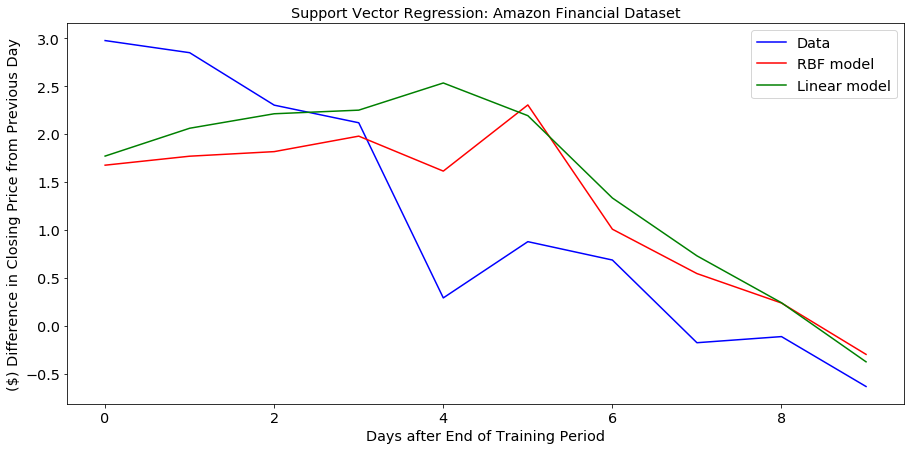

In [113]:
from sklearn.svm import SVR
X_amazon= amazon_wiki_senti.drop(columns=["Open", "Close", "upordown", "Low", "High", "polarity", "relatedness_content", "relatedness_title", "subjectivity", "Month", "year", "Visits"])
y_amazon = amazon_wiki_senti[["Close"]]
split = int(len(amazon_wiki_senti)*0.8)
X_train_amazon, X_test_amazon, y_train_amazon, y_test_amazon = X_amazon[:split], X_amazon[split:], y_amazon[:split], y_amazon[split:]

X_train_amazon = (X_train_amazon - X_train_amazon.mean())/X_train_amazon.std()
X_test_amazon = (X_test_amazon - X_test_amazon.mean())/X_test_amazon.std()
y_train_amazon = (y_train_amazon - y_train_amazon.mean())/y_train_amazon.std()
y_test_amazon = (y_test_amazon - y_test_amazon.mean())/y_test_amazon.std()

y_train_amazon = y_train_amazon.as_matrix().ravel()
y_test_amazon  = y_test_amazon.as_matrix().ravel()
X_train_amazon = X_train_amazon.as_matrix()
X_test_amazon  = X_test_amazon.as_matrix()

svr_lin = SVR(kernel= 'linear', C= 1e3)
# svr_sigmoid =SVR(kernel= 'sigmoid', C= 1e3, degree= 2)
svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)


svr_lin.fit(X_train_amazon,y_train_amazon ) # fitting the data points in the models
# svr_sigmoid.fit(X_train_amazon,y_train_amazon ) # fitting the data points in the models
svr_rbf.fit(X_train_amazon,y_train_amazon) # fitting the data points in the models

plt.figure(figsize=(15,7))
plt.plot( y_test_amazon[:10], color= 'b', label= 'Data') # plotting the initial datapoints 
plt.plot(svr_rbf.predict(X_test_amazon[:10]), color= 'red', label= 'RBF model') # plotting the line made by the RBF kernel
plt.plot(svr_lin.predict(X_test_amazon[:10]), color= 'green', label= 'Linear model') # plotting the line made by linear kernel
plt.xlabel('Days after End of Training Period')
plt.ylabel('($) Difference in Closing Price from Previous Day')
plt.title('Support Vector Regression: Amazon Financial Dataset')
plt.legend()
plt.show()

# print("Error: SVR rbf " , abs((y_test_amazon[:10] - svr_rbf.predict(X_test_amazon[:10])).mean()))
# print("Error: SVR linear " , abs((y_test_amazon[:10] - svr_lin.predict(X_test_amazon[:10])).mean()))

ml_metrics['svr rbf: amazon finance'] = get_model_metrics(y_test_amazon[:10], svr_rbf.predict(X_test_amazon[:10]), ML_SVR_RBF, DATASET_AMZN)
ml_metrics['svr linear: amazon finance'] = get_model_metrics(y_test_amazon[:10], svr_lin.predict(X_test_amazon[:10]), ML_SVR_LINEAR, DATASET_AMZN)

### ML support vector regression -- Amazon + Wiki
#### Getting training and test sets from the Amazon +  Wiki Dataset

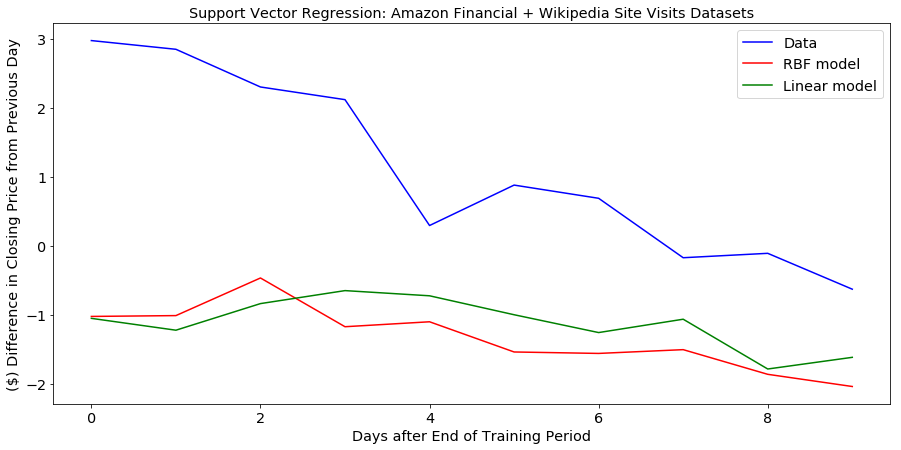

In [114]:
X_wiki= amazon_wiki_senti.drop(columns=["Open", "Close", "upordown", "Low", "High", "polarity", "relatedness_content", "relatedness_title", "subjectivity", "Month", "year"])
y_wiki = amazon_wiki_senti[["Close"]]
split = int(len(amazon_wiki_senti)*0.8)
X_train_wiki, X_test_wiki, y_train_wiki, y_test_wiki = X_wiki[:split], X_wiki[split:], y_wiki[:split], y_wiki[split:]

X_train_wiki = (X_train_wiki - X_train_wiki.mean())/X_train_wiki.std()
X_test_wiki = (X_test_wiki - X_test_wiki.mean())/X_test_wiki.std()
y_train_wiki = (y_train_wiki - y_train_wiki.mean())/y_train_wiki.std()
y_test_wiki = (y_test_wiki - y_test_wiki.mean())/y_test_wiki.std()

y_train_wiki = y_train_wiki.as_matrix().ravel()
y_test_wiki  = y_test_wiki.as_matrix().ravel()
X_train_wiki = X_train_wiki.as_matrix()
X_test_wiki  = X_test_wiki.as_matrix()

svr_lin = SVR(kernel= 'linear', C= 1e3)
# svr_sigmoid =SVR(kernel= 'sigmoid', C= 1e3, degree= 2)
svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)


svr_lin.fit(X_train_wiki,y_train_wiki ) # fitting the data points in the models
# svr_sigmoid.fit(X_train_wiki,y_train_wiki ) # fitting the data points in the models
svr_rbf.fit(X_train_wiki,y_train_wiki) # fitting the data points in the models

plt.figure(figsize=(15,7))
plt.plot( y_test_wiki[:10], color= 'b', label= 'Data') # plotting the initial datapoints 
plt.plot(svr_rbf.predict(X_train_wiki[:10]), color= 'red', label= 'RBF model') # plotting the line made by the RBF kernel
plt.plot(svr_lin.predict(X_train_wiki[:10]), color= 'green', label= 'Linear model') # plotting the line made by linear kernel
plt.xlabel('Days after End of Training Period')
plt.ylabel('($) Difference in Closing Price from Previous Day')
plt.title('Support Vector Regression: Amazon Financial + Wikipedia Site Visits Datasets')
plt.legend()
plt.show()

# print("Error: SVR rbf " , abs((y_test_wiki[:10] - svr_rbf.predict(X_test_wiki[:10])).mean()))
# print("Error: SVR linear " , abs((y_test_wiki[:10] - svr_lin.predict(X_test_wiki[:10])).mean()))

ml_metrics['svr rbf: amazon finance + wikipedia visits'] = get_model_metrics(y_test_wiki[:10], svr_rbf.predict(X_test_wiki[:10]), ML_SVR_RBF, DATASET_AMZN_WIKI)
ml_metrics['svr linear: amazon finance wikipedia visits'] = get_model_metrics(y_test_wiki[:10], svr_lin.predict(X_test_wiki[:10]), ML_SVR_LINEAR, DATASET_AMZN_WIKI)

### ML support vector regression -- Amazon + Sentiment
#### Getting training and test sets from the Amazon + Sentiment Dataset

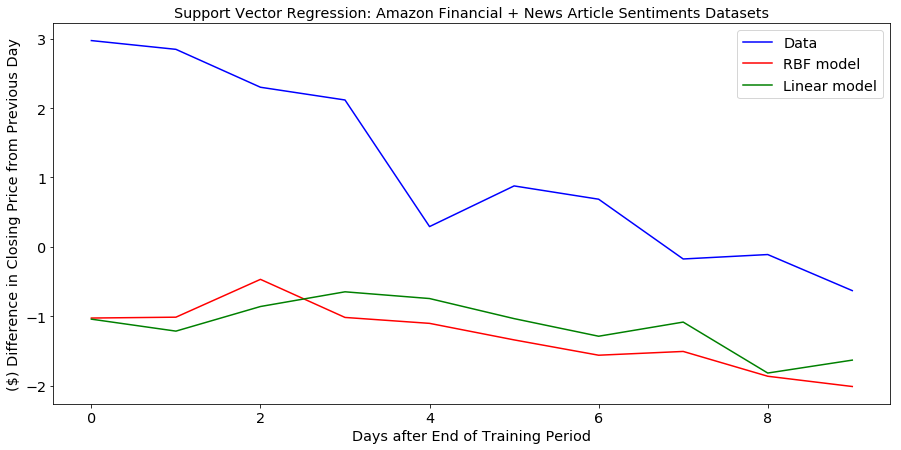

In [214]:
X_senti= amazon_wiki_senti.drop(columns=["Open", "Close", "upordown", "Low", "High", "Month", "year", "Visits"])
y_senti = amazon_wiki_senti[["Close"]]
split = int(len(amazon_wiki_senti)*0.8)
X_train_senti, X_test_senti, y_train_senti, y_test_senti = X_senti[:split], X_senti[split:], y_senti[:split], y_senti[split:]

X_train_senti = (X_train_senti - X_train_senti.mean())/X_train_senti.std()
X_test_senti = (X_test_senti - X_test_senti.mean())/X_test_senti.std()
y_train_senti = (y_train_senti - y_train_senti.mean())/y_train_senti.std()
y_test_senti = (y_test_senti - y_test_senti.mean())/y_test_senti.std()

y_train_senti = y_train_senti.as_matrix().ravel()
y_test_senti  = y_test_senti.as_matrix().ravel()
X_train_senti = X_train_senti.as_matrix()
X_test_senti  = X_test_senti.as_matrix()

svr_lin = SVR(kernel= 'linear', C= 1e3)
# svr_sigmoid =SVR(kernel= 'sigmoid', C= 1e3, degree= 2)
svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)


svr_lin.fit(X_train_senti,y_train_senti ) # fitting the data points in the models
# svr_sigmoid.fit(X_train_senti,y_train_senti ) # fitting the data points in the models
svr_rbf.fit(X_train_senti,y_train_senti) # fitting the data points in the models

plt.figure(figsize=(15,7))
plt.plot( y_test_senti[:10], color= 'b', label= 'Data') # plotting the initial datapoints 
plt.plot(svr_rbf.predict(X_train_senti[:10]), color= 'red', label= 'RBF model') # plotting the line made by the RBF kernel
plt.plot(svr_lin.predict(X_train_senti[:10]), color= 'green', label= 'Linear model') # plotting the line made by linear kernel
plt.xlabel('Days after End of Training Period')
plt.ylabel('($) Difference in Closing Price from Previous Day')
plt.title('Support Vector Regression: Amazon Financial + News Article Sentiments Datasets')
plt.legend()
plt.show()

# print("Error: SVR rbf " , abs((y_test_senti[:10] - svr_rbf.predict(X_test_senti[:10])).mean()))
# print("Error: SVR linear " , abs((y_test_senti[:10] - svr_lin.predict(X_test_senti[:10])).mean()))

ml_metrics['svr rbf: amazon finance + news article sentient'] = get_model_metrics(y_test_senti[:10], svr_rbf.predict(X_test_senti[:10]), ML_SVR_RBF, DATASET_AMZN_SENT)
ml_metrics['svr linear: amazon finance + news article sentient'] = get_model_metrics(y_test_senti[:10], svr_lin.predict(X_test_senti[:10]), ML_SVR_LINEAR, DATASET_AMZN_SENT)


### ML support vector regression -- Amazon + Wikipedia + Sentiment
#### Getting training and test sets from the Amazon +  Wiki +  Sentiment Dataset

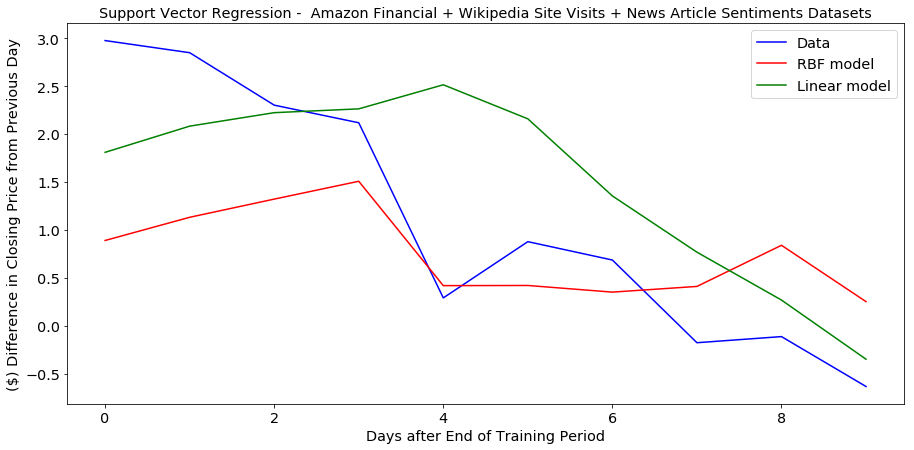

In [116]:
from sklearn.svm import SVR

X_train_norm = (X_train - X_train.mean())/X_train.std()
X_test_norm = (X_test - X_test.mean())/X_test.std()
y_train_norm = (y_train - y_train.mean())/y_train.std()
y_test_norm = (y_test - y_test.mean())/y_test.std()


y_train_svm = y_train_norm.as_matrix().ravel()
X_train_svm = X_train_norm.as_matrix()
X_test_svm = X_test_norm.as_matrix()
y_test_svm = y_test_norm.as_matrix().ravel()

y_train_all = y_train_svm
X_train_all = X_train_svm 
X_test_all =X_test_svm  
y_test_all = y_test_svm 


svr_lin = SVR(kernel= 'linear', C= 1e3)
# svr_sigmoid =SVR(kernel= 'sigmoid', C= 1e3, degree= 2)
svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)


svr_lin.fit(X_train_svm,y_train_svm ) # fitting the data points in the models
# svr_sigmoid.fit(X_train_svm,y_train_svm ) # fitting the data points in the models
svr_rbf.fit(X_train_svm,y_train_svm ) # fitting the data points in the models

plt.figure(figsize=(15,7))
plt.plot( y_test_svm[:10], color= 'b', label= 'Data') # plotting the initial datapoints 
plt.plot(svr_rbf.predict(X_test_svm[:10]), color= 'red', label= 'RBF model') # plotting the line made by the RBF kernel
plt.plot(svr_lin.predict(X_test_svm[:10]), color= 'green', label= 'Linear model') # plotting the line made by linear kernel
plt.xlabel('Days after End of Training Period')
plt.ylabel('($) Difference in Closing Price from Previous Day')
plt.title('Support Vector Regression -  Amazon Financial + Wikipedia Site Visits + News Article Sentiments Datasets')
plt.legend()
plt.show()

# print("Error: SVR rbf " , abs((y_test_svm[:10] - svr_rbf.predict(X_test_svm[:10])).mean()))
# print("Error: SVR linear " , abs((y_test_svm[:10] - svr_lin.predict(X_test_svm[:10])).mean()))

ml_metrics['svr rbf: amazon finance + Wikipedia visits + news article sentient'] = get_model_metrics(y_test_svm[:10], svr_rbf.predict(X_test_svm[:10]), ML_SVR_RBF, DATASET_COMBINED)
ml_metrics['svr linear: amazon finance + Wikipedia visits + news article sentient'] = get_model_metrics(y_test_svm[:10], svr_lin.predict(X_test_svm[:10]), ML_SVR_LINEAR, DATASET_COMBINED)


[Back to Table of Contents](#toc)

<a id="toc3b"></a>
# 3b. Deep Learning

For deep learning, we used an abstraction level API build on top of tensor flow, which makes for really fast deployment for neural network. We were able to quickly and easily stack perceptrons or neurons making a multi-level neural network. We used a general feed forward neural network, that took the input data through two layers or weighting the through 128 neurons in the first layers then reweighting the 256 neurons in second layer. For optimization, we used the adam optimization, which is similar to stochastic gradient descent learned in class. For some models depending on the accuracy we used different layers, however keeping the same general premise of the model which is the feedforward network.

#### Deep learning -- Amazon Dataset(s)

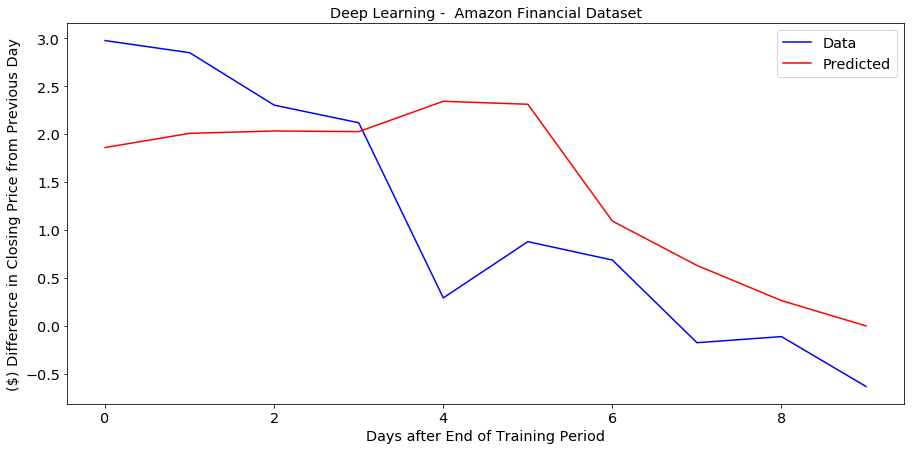

In [194]:
model = Sequential()
model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train_amazon.shape[1]))
model.add(Dense(units = 256,kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'relu'))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
model.fit(X_train_amazon, y_train_amazon, batch_size = 10, epochs = 1000, verbose=0)

y_pred_amazon = model.predict(X_test_amazon[:10])
plt.figure(figsize=(15,7))
plt.plot(y_test_amazon[:10], color='b', label='Data')
plt.plot(y_pred_amazon[:10] , color='r', label='Predicted')
plt.xlabel('Days after End of Training Period')
plt.ylabel('($) Difference in Closing Price from Previous Day')
plt.title('Deep Learning -  Amazon Financial Dataset')
plt.legend()
plt.show()
# print("Error: ",  abs(( model.predict(X_test_amazon[:10]) - y_test_amazon[:10]).mean()))

dl_metrics['Deep Learning: amazon finance'] = get_model_metrics(y_test_amazon[:10], model.predict(X_test_amazon[:10]), DL_NEURAL_NET, DATASET_AMZN)

#### Deep Learning -- Amazon + Wikipedia Datasets

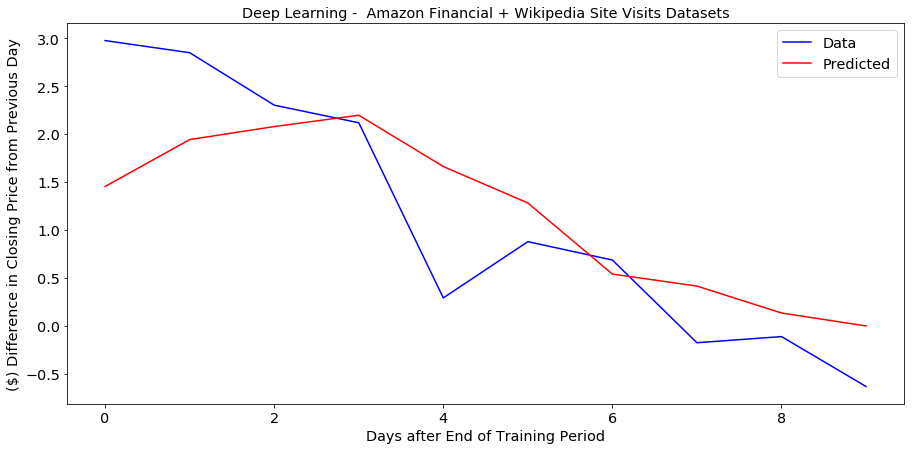

In [207]:
model_wiki = Sequential()
model_wiki.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train_wiki.shape[1]))
model_wiki.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'relu'))
model_wiki.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
model_wiki.fit(X_train_wiki, y_train_wiki, batch_size = 10, epochs = 1000, verbose=0)

y_pred_wiki = model_wiki.predict(X_test_wiki[:10])
plt.figure(figsize=(15,7))
plt.plot(y_test_wiki[:10], color='b', label='Data')
plt.plot(y_pred_wiki[:10] , color='r', label='Predicted')
plt.xlabel('Days after End of Training Period')
plt.ylabel('($) Difference in Closing Price from Previous Day')
plt.title('Deep Learning -  Amazon Financial + Wikipedia Site Visits Datasets')
plt.legend()
plt.show()
# print("Error: ",  abs(( model_wiki.predict(X_test_wiki[:10]) - y_test_wiki[:10]).mean()))

dl_metrics['Deep Learning: amazon finance + Wikipedia visits'] = get_model_metrics(y_test_wiki[:10], model_wiki.predict(X_test_wiki[:10]), DL_NEURAL_NET, DATASET_AMZN_WIKI)

#### Deep learning -- Amazon + Sentiment Datasets

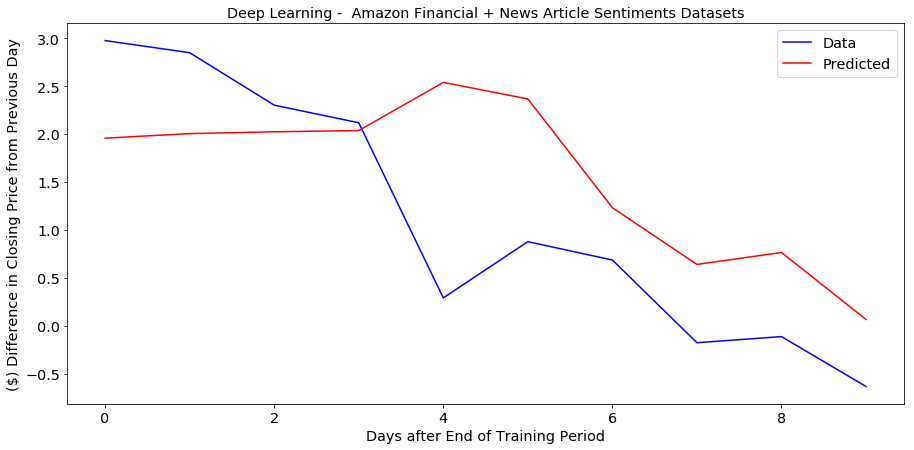

In [196]:
model_senti = Sequential()
model_senti.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train_senti.shape[1]))
model_senti.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'relu'))
model_senti.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
model_senti.fit(X_train_senti, y_train_senti, batch_size = 10, epochs = 1000, verbose=0)

y_pred_senti = model_senti.predict(X_test_senti[:10])
plt.figure(figsize=(15,7))
plt.plot(y_test_senti[:10], color='b', label='Data')
plt.plot(y_pred_senti[:10] , color='r', label='Predicted')
plt.xlabel('Days after End of Training Period')
plt.ylabel('($) Difference in Closing Price from Previous Day')
plt.title('Deep Learning -  Amazon Financial + News Article Sentiments Datasets')
plt.legend()
plt.show()
# print("Error: ",  abs(( model_senti.predict(X_test_senti[:10]) - y_test_senti[:10]).mean()))

dl_metrics['Deep Learning: amazon finance + news article sentient'] = get_model_metrics(y_test_senti[:10], model_senti.predict(X_test_senti[:10]), DL_NEURAL_NET, DATASET_AMZN_SENT)


#### Deep Learning -- Amazon + Sentiment +  Wikipedia Datasets

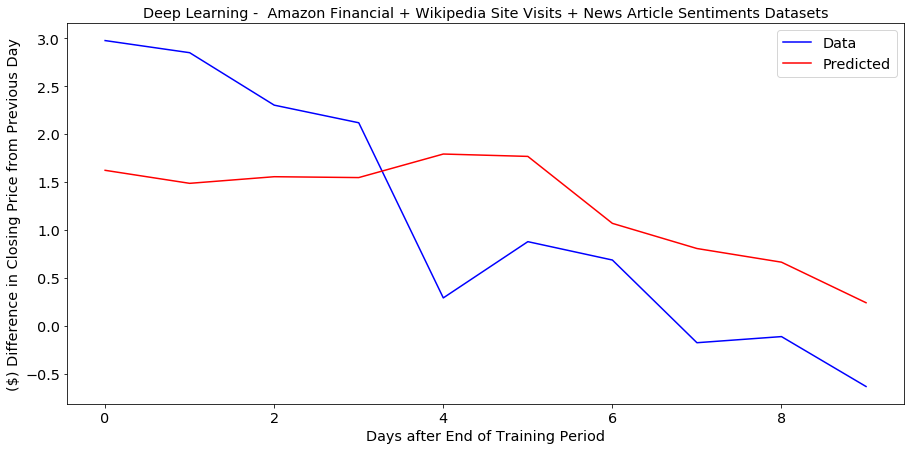

In [197]:
X_train_norm = (X_train - X_train.mean())/X_train.std()
X_test_norm = (X_test - X_test.mean())/X_test.std()
y_train_norm = (y_train - y_train.mean())/y_train.std()
y_test_norm = (y_test - y_test.mean())/y_test.std()


y_train_svm = y_train_norm.as_matrix().ravel()
X_train_svm = X_train_norm.as_matrix()
X_test_svm = X_test_norm.as_matrix()
y_test_svm = y_test_norm.as_matrix().ravel()

y_train_all = y_train_svm
X_train_all = X_train_svm 
X_test_all =X_test_svm  
y_test_all = y_test_svm

classifier = Sequential()
classifier.add(Dense(units = 300, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
classifier.add(Dense(units = 120, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
classifier.fit(X_train_all, y_train_all, batch_size = 10, epochs = 1000, verbose=0)

y_pred = classifier.predict(X_test_all[:10])
plt.figure(figsize=(15,7))
plt.plot( y_test_all[:10], color= 'b', label= 'Data') # plotting the initial datapoints 
plt.plot( y_pred[:10], color='r', label= 'Predicted') # plotting the initial datapoints 
plt.xlabel('Days after End of Training Period')
plt.ylabel('($) Difference in Closing Price from Previous Day')
plt.title('Deep Learning -  Amazon Financial + Wikipedia Site Visits + News Article Sentiments Datasets')
plt.legend()
plt.show()

# print("Error: ",  abs((classifier.predict(X_test[:10]) - y_test[:10]).mean()))

dl_metrics['Deep Learning: amazon finance + wikipedia site visits + news article sentient'] = get_model_metrics(y_test_all[:10], classifier.predict(X_test_all[:10]), DL_NEURAL_NET, DATASET_COMBINED)


<a id="toc4"></a>
# 4. Results

In [209]:
dl_metrics_df = pd.DataFrame()
for trial, metrics in dl_metrics.items():
    tmp_df = pd.DataFrame().from_dict(metrics)
    dl_metrics_df = pd.concat([dl_metrics_df, tmp_df])
dl_metrics_df = dl_metrics_df.set_index('Dataset')

ml_metrics_df = pd.DataFrame()
for trial, metrics in ml_metrics.items():
    tmp_df = pd.DataFrame().from_dict(metrics)
    ml_metrics_df = pd.concat([ml_metrics_df, tmp_df])
ml_metrics_df = ml_metrics_df.set_index('Dataset')

### Results from Neural Networks

##### Discussion:
From the bar plots of the metrics below, it can be seen that the Amazon Finance + Wikipedia Visits datasets were the most impactful in terms of having the lowest error across the board **Mean Absolute Error**, **Mean Squared Error**, **Median Absolute Error**, as well as the highest **R2** Score. However, it does have a higher variance score than the rest of the datasets.

In [210]:
dl_metrics_df = dl_metrics_df[['Explained Variance Score', 'Mean Absolute Error', 'Mean Squared Error', 'Median Absolute Error', 'R2 Score']]

,Explained Variance Score,Mean Absolute Error,Mean Squared Error,Median Absolute Error,R2 Score
Dataset,,,,,
Amazon Finance,0.469599,0.801634,0.963364,0.718459,0.398127
Amazon Finance + Wikipedia Visits,0.623439,0.611386,0.605460,0.496800,0.621732
Amazon Finance + News Article Sentiments,0.417359,0.888977,1.130727,0.829754,0.293565
Amazon Finance + Wikipedia Visits + News Article Sentiments,0.382076,0.943237,1.007826,0.880983,0.370349


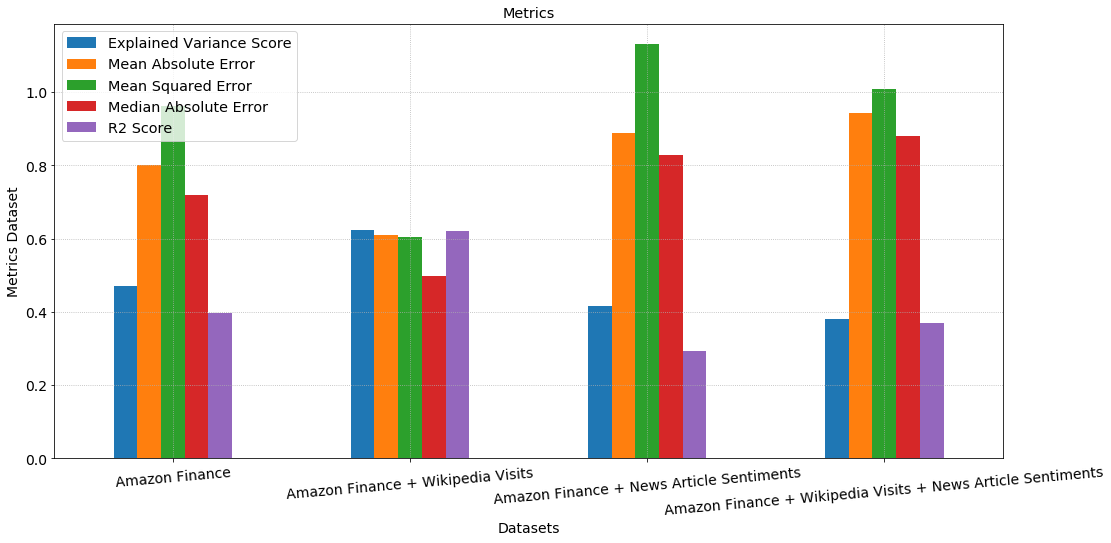

In [211]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False)
fig.set_size_inches(17, 8)
fig.subplots_adjust(hspace=.5)

dl_metrics_plot_args = {
    'kind' : 'bar',
    'fontsize' : 14,
    'title' : 'Metrics',
    'ax' : axes,
    'rot' : 5
}

dl_metrics_plot = dl_metrics_df.plot(**dl_metrics_plot_args)
dl_metrics_plot.set_ylabel('Metrics Dataset', fontsize=14)
dl_metrics_plot.set_xlabel('Datasets', fontsize=14)
dl_metrics_plot.grid('on', which='both', linestyle=':')

axes.legend(loc='best')
dl_metrics_df.head()

### Results from SVR-RBF

##### Discussion:
The data below on the SVR show that the first two datasets with Amazon finance data and Amazon finance data with Wikipedia Site Visit data did much better than when News Article Sentiments were introduced.
We see that the error where Wikipedia data was involved is much lower than when it was not. Also, the R2 score is higher, indicating that the model trained on datasets where Wikipedia site visits was involved predict things lie in the future better.

In [181]:
ml_metrics_svr_rbf_df = ml_metrics_df.where(ml_metrics_df.Model == ML_SVR_RBF).dropna()

,Model,Explained Variance Score,Mean Absolute Error,Mean Squared Error,Median Absolute Error,R2 Score
Dataset,,,,,,
Amazon Finance,SVR - RBF,0.530004,0.747511,0.773958,0.602632,0.516461
Amazon Finance + Wikipedia Visits,SVR - RBF,0.582070,0.664471,0.705001,0.541687,0.559543
Amazon Finance + News Article Sentiments,SVR - RBF,0.401095,0.832356,0.967164,0.774591,0.395753
Amazon Finance + Wikipedia Visits + News Article Sentiments,SVR - RBF,0.395956,0.873052,1.098490,0.747211,0.313706


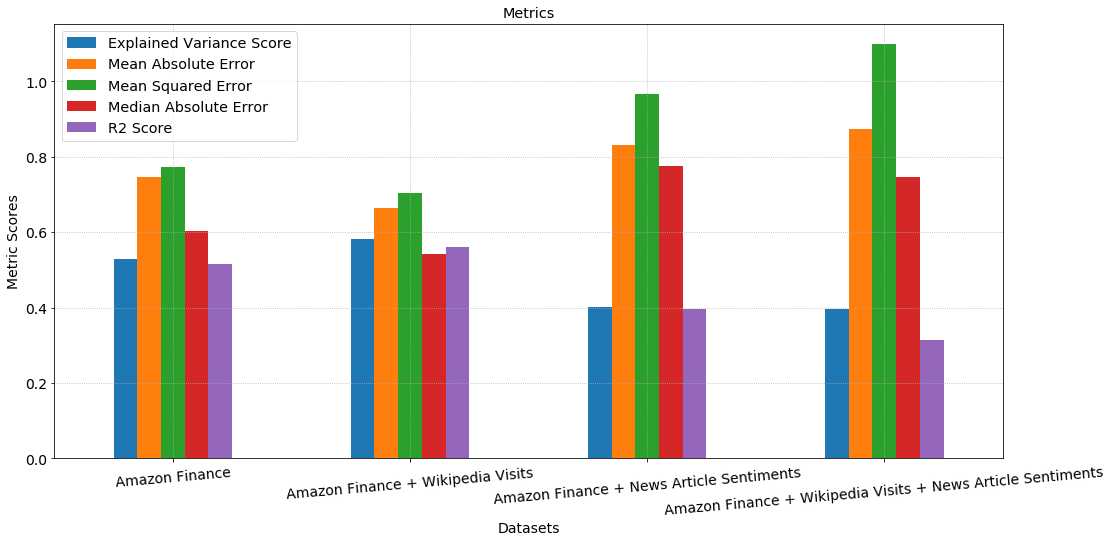

In [200]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False)
fig.set_size_inches(17, 8)
fig.subplots_adjust(hspace=.5)

ml_metrics_svr_rbf_plot_args = {
    'kind' : 'bar',
    'fontsize' : 14,
    'title' : 'Metrics',
    'ax' : axes,
    'rot' : 5
}

ml_metrics_svr_rbf_plot = ml_metrics_svr_rbf_df.plot(**ml_metrics_svr_rbf_plot_args)
ml_metrics_svr_rbf_plot.set_ylabel('Metric Scores', fontsize=14)
ml_metrics_svr_rbf_plot.set_xlabel('Datasets', fontsize=14)
ml_metrics_svr_rbf_plot.grid('on', which='both', linestyle=':')

axes.legend(loc='best')

ml_metrics_svr_rbf_df

### Results for SVR-Linear

##### Discussion:
In the results below, we see that the SVR-Linear model performs similarily for all datasets. However, we notice that the **mean squared error**, **median absolute error**, and **R2** improve slightly when the news article sentiments dataset was introduced. The mean squared error and the median absolute error went down slightly, while the R2 score went up slightly for those two datasetes where News Article Sentiments was introduced.

In [184]:
ml_metrics_svr_linear_df = ml_metrics_df.where(ml_metrics_df.Model == ML_SVR_LINEAR).dropna()

,Model,Explained Variance Score,Mean Absolute Error,Mean Squared Error,Median Absolute Error,R2 Score
Dataset,,,,,,
Amazon Finance,SVR - Linear,0.447186,0.792844,1.026664,0.717005,0.358580
Amazon Finance + Wikipedia Visits,SVR - Linear,0.442588,0.798405,1.040797,0.721795,0.349750
Amazon Finance + News Article Sentiments,SVR - Linear,0.464579,0.790863,1.007532,0.714090,0.370532
Amazon Finance + Wikipedia Visits + News Article Sentiments,SVR - Linear,0.464304,0.793261,1.010704,0.716848,0.368551


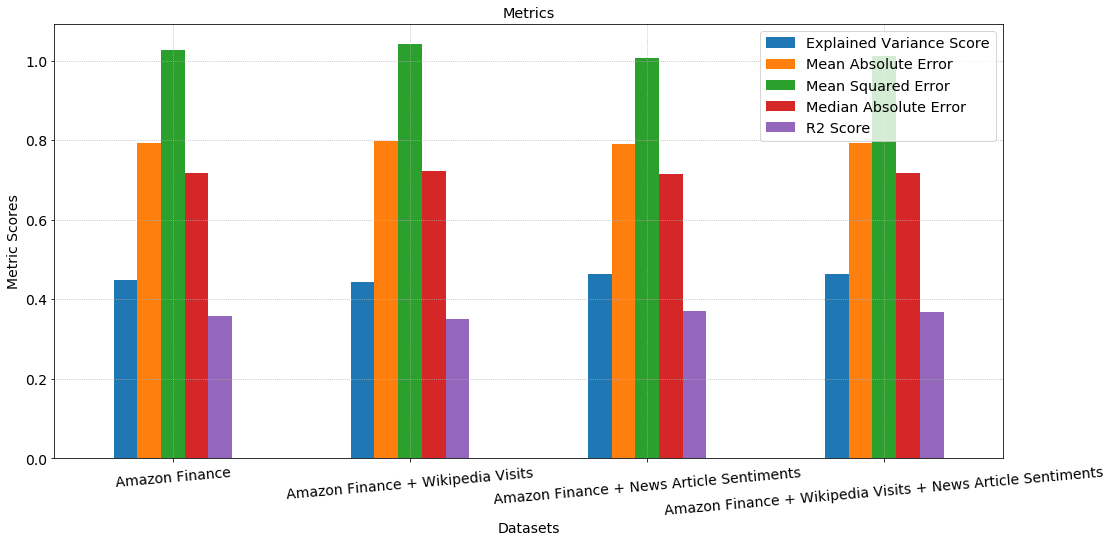

In [202]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False)
fig.set_size_inches(17, 8)
fig.subplots_adjust(hspace=.5)

ml_metrics_svr_linear_plot_args = {
    'kind' : 'bar',
    'fontsize' : 14,
    'title' : 'Metrics',
    'ax' : axes,
    'rot' : 5
}

ml_metrics_svr_linear_plot = ml_metrics_svr_linear_df.plot(**ml_metrics_svr_linear_plot_args)
ml_metrics_svr_linear_plot.set_ylabel('Metric Scores', fontsize=14)
ml_metrics_svr_linear_plot.set_xlabel('Datasets', fontsize=14)
ml_metrics_svr_linear_plot.grid('on', which='both', linestyle=':')

axes.legend(loc='best')

ml_metrics_svr_linear_df

[Back to Table of Contents](#toc)

## Summary of Results

<div class="alert alert-block alert-info">
<b>In Conclusion:</b>
<br>
For the two out of the three models that we've used, the Amazon Finance + Wikipedia Visits gave the most promising results. The Neural Network that we used and the Support Vector Machine - Radial Base Function were the two that showed this.
<br>
<br>
Whereas, in the Support Vector Machine - Linear Kernel model, the results were similar across the board, and it is difficult to discern which dataset resulted in a better better in terms of lower error and higher R2 score.
<br>
<br>
From these results, it's observed that that Wikipedia Visits paired with Amazon Financial data results in a good regression models when using Neural Networks or SVR-RBF. However, the question still lies: does News Articles not play a factor in Stock Markets? That is a question that is still too early to answer, even with our results. It could be that just like training a model, we have to tune the way we preprocess our News Articles and its sentiments to get the most effective news articles and its relative scores. The wikipedia dataset definitely shows promise in indicating how well a stock performs compared to news articles, though.
</div>


<a id="toc5"></a>
# 5. Future outlook

**What did we learn? What is the vision behind this project? **

By performing this experiment, we can apply our knowledge gained to a lot of different time series datasets. Having a good understanding of how to deal with time series datasets, we can interchangeably apply our knowledge different studies to gain valuable insights in other topics.

While taking this course we realized how the preprocessing datasets is in itself a big task. With the proliferation of ML and deep learning libraries, there seems a lot of focus in that space. However, we learned that it is equally important to have a proper data pipeline to order to serve the models you create. Also, we learned some valuable skills regarding normalizing and cleaning our datasets in order to prep for the ML and deep learning.

Machine learning, our models depend heavily on feature engineering, in the future we could try to avoid that by using a different kind of learning approach. Also, we experimented with SVR, other models like random forest, naive Bayes and ensemble method seem plausible in term of experimentation.  

LSTM and RNN, after learning about the recurrent neural network and the long-short term model we think that these models might help us better predict the prices due to the networks being able to go back and reweight its neuron or in the case of LSTM it remembers the most recent behavior. 

Another improvement we could make is in the preprocessing of the News Articles data for sentiment scores. Our results show that News Article Sentiment is not as good an indicator as the Wikipedia Site Visits feature. However, more improvement could be made on determining what is a good score to include when using News Articles Sentiment.

<a id="toc6"></a>
# 6. References

> ### 1 http://cs229.stanford.edu/proj2009/KingVandrotWeng.pdf
> ### 2 https://www.kaggle.com/muonneutrino/wikipedia-traffic-data-exploration
> ### 3 https://medium.com/@yangforbig/introduction-to-machine-learning-lesson-2-and-lesson-3-25569d9bafa4
> ### 4 https://www.saedsayad.com/support_vector_machine_reg.htm
> ### 5 https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
> ### 6 https://arrow.dit.ie/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1025&context=scschcomart
> ### 7 http://cs229.stanford.edu/proj2016spr/report/010.pdf
> ### 8 https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5609404&tag=1
> ### 9 https://ieeexplore.ieee.org/document/6480222